<a href="https://colab.research.google.com/github/ROHAN010501/ML_Projects/blob/main/pune_temperature_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pune Temperature Prediction Using ARIMA and SARIMAX

### Importing the Libraries

In [7]:
# importing libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

### Exploring the dataset

In [8]:
# reading the dataset
df0 = pd.read_csv(r"https://github.com/ROHAN010501/data/raw/refs/heads/main/pune_transformed_weather_data.csv")
new_df = df0.copy().iloc[2556:, [1, 2, 3, 4]].reset_index(drop=True)

In [9]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2192 entries, 0 to 2191
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date_time  2192 non-null   object 
 1   maxtempC   2192 non-null   float64
 2   mintempC   2192 non-null   float64
 3   tempC      2192 non-null   float64
dtypes: float64(3), object(1)
memory usage: 68.6+ KB


In [10]:
# converting the data type of "date_time" from "float" to "date time"
new_df["date_time"] = pd.to_datetime(new_df["date_time"])

In [11]:
new_df.head()

date_time  maxtempC  mintempC      tempC
0 2016-01-01      33.0      19.0  24.958333
1 2016-01-02      32.0      20.0  25.041667
2 2016-01-03      32.0      19.0  24.416667
3 2016-01-04      30.0      18.0  22.916667
4 2016-01-05      32.0      19.0  23.958333

In [12]:
new_df.tail()

date_time  maxtempC  mintempC      tempC
2187 2021-12-27      30.0      18.0  23.083333
2188 2021-12-28      30.0      18.0  22.833333
2189 2021-12-29      28.0      15.0  21.250000
2190 2021-12-30      27.0      16.0  21.250000
2191 2021-12-31      29.0      18.0  22.625000

In [13]:
# setting the "date_time" as index of dataset
new_df.set_index("date_time", inplace=True)

In [14]:
# resampling the dataset to weekwise data to decrease the size of the dataset and applying respective aggregations
df = new_df.resample('W').agg({
    'maxtempC': 'max',
    'mintempC': 'min',
    'tempC': 'mean'
})

In [15]:
df.head()

maxtempC  mintempC      tempC
date_time                                
2016-01-03      33.0      19.0  24.805556
2016-01-10      32.0      18.0  23.446429
2016-01-17      31.0      15.0  22.065476
2016-01-24      31.0      14.0  20.952381
2016-01-31      36.0      18.0  25.053571

In [16]:
df.tail()

maxtempC  mintempC      tempC
date_time                                
2021-12-05      29.0      15.0  20.833333
2021-12-12      29.0      17.0  22.648810
2021-12-19      29.0      14.0  22.202381
2021-12-26      30.0      14.0  21.821429
2022-01-02      30.0      15.0  22.208333

In [17]:
df.shape

(314, 3)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 314 entries, 2016-01-03 to 2022-01-02
Freq: W-SUN
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   maxtempC  314 non-null    float64
 1   mintempC  314 non-null    float64
 2   tempC     314 non-null    float64
dtypes: float64(3)
memory usage: 9.8 KB


In [19]:
df['tempC'] = round(df['tempC'])

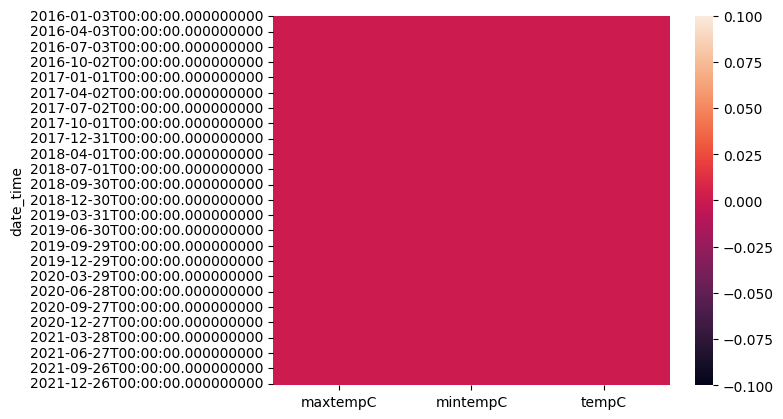

In [20]:
#plotting heatmap to see if there are any null values
sns.heatmap(df.isnull())
plt.show()

### solving for Average Temperature

In [21]:
#creating training and testing datasets for avg temp

Train_avg = df.iloc[:261, :].copy()

Test_avg = df.iloc[261:, :].copy()

In [22]:
Test_avg.head()

maxtempC  mintempC  tempC
date_time                            
2021-01-03      31.0      17.0   24.0
2021-01-10      30.0      19.0   24.0
2021-01-17      31.0      20.0   25.0
2021-01-24      33.0      20.0   26.0
2021-01-31      33.0      19.0   25.0

In [23]:
Train_avg.tail()

maxtempC  mintempC  tempC
date_time                            
2020-11-29      29.0      18.0   23.0
2020-12-06      30.0      17.0   24.0
2020-12-13      29.0      17.0   23.0
2020-12-20      29.0      16.0   23.0
2020-12-27      30.0      15.0   22.0

In [24]:
Train_avg.shape

(261, 3)

In [25]:
Test_avg.shape

(53, 3)

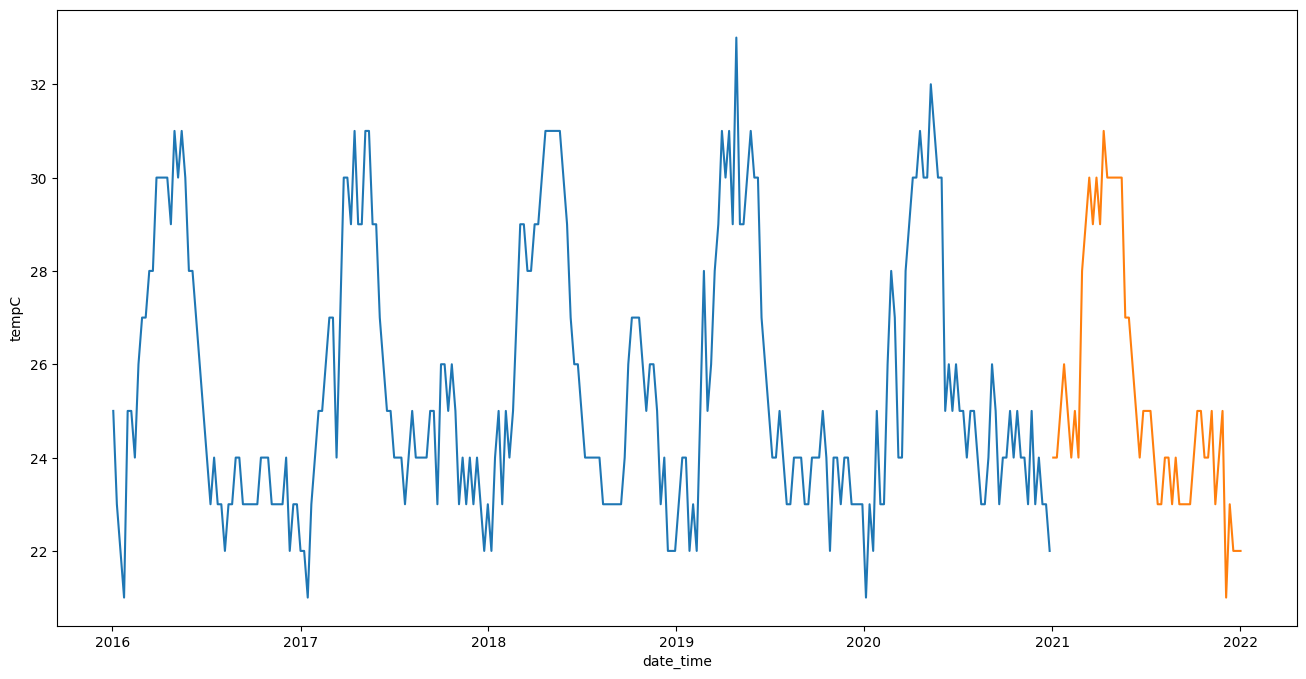

In [26]:
# plotting the average temperature data
plt.figure(figsize=(16, 8))

sns.lineplot(data=Train_avg, x='date_time', y='tempC')
sns.lineplot(data=Test_avg, x='date_time', y='tempC')

plt.show()

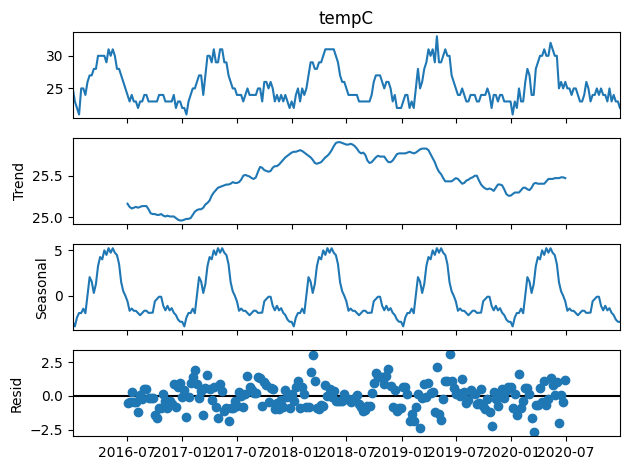

In [27]:
#plotting decomposed time series
s_decompose = seasonal_decompose(Train_avg['tempC'], model='additive', period=52)
s_decompose.plot()
plt.show()

In [28]:
# creating the function to calculate stationarity and plot the graphs
def test_stationarity(t_data, data_series, roll_window=0):
    """This function takes table name, target column name and roll window value and
    calculates p-value using adfuller test and plot the graphs for rolling mean and standard deviation."""
    # Perform the Augmented Dickey-Fuller test
    adftest = adfuller(t_data[data_series].dropna(), autolag='AIC')
    pval = adftest[1]
    print(f"The p-value is: {pval}")

    # Calculate rolling statistics
    roll_mean = t_data[data_series].rolling(window=roll_window).mean()
    roll_std = t_data[data_series].rolling(window=roll_window).std()

    # Plotting
    plt.figure(figsize=(16, 8))
    plt.plot(t_data.index, t_data[data_series], label= 'diff', color='blue')
    plt.plot(t_data.index, roll_mean, label=f'Rolling Mean (window={roll_window})', color='red')
    plt.plot(t_data.index, roll_std, label=f'Rolling Std Dev (window={roll_window})', color='green')
    plt.legend(loc='best')
    plt.title(f'Stationarity Test with Rolling Window = {roll_window}')
    plt.xlabel('Date')
    plt.ylabel(data_series)

    plt.show()


The p-value is: 0.00017139460752163806


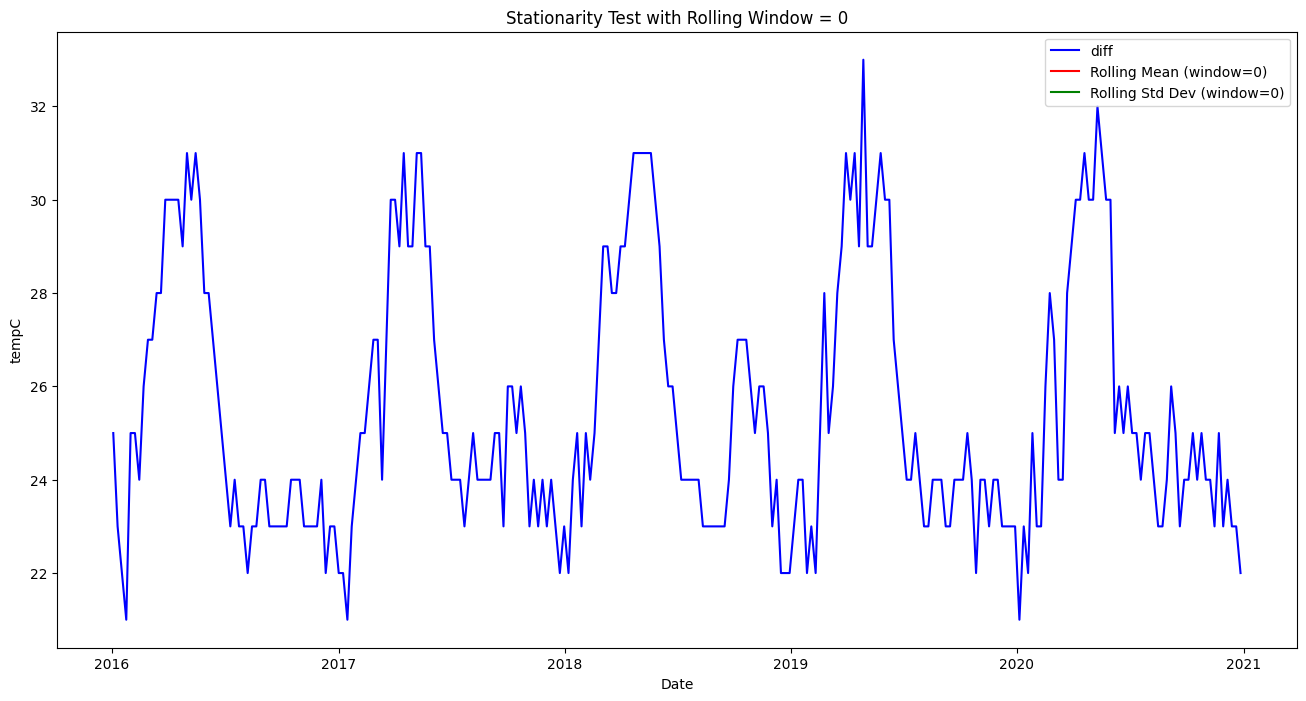

In [29]:
test_stationarity(Train_avg, "tempC", 0)

The p-value is: 0.00017139460752163806


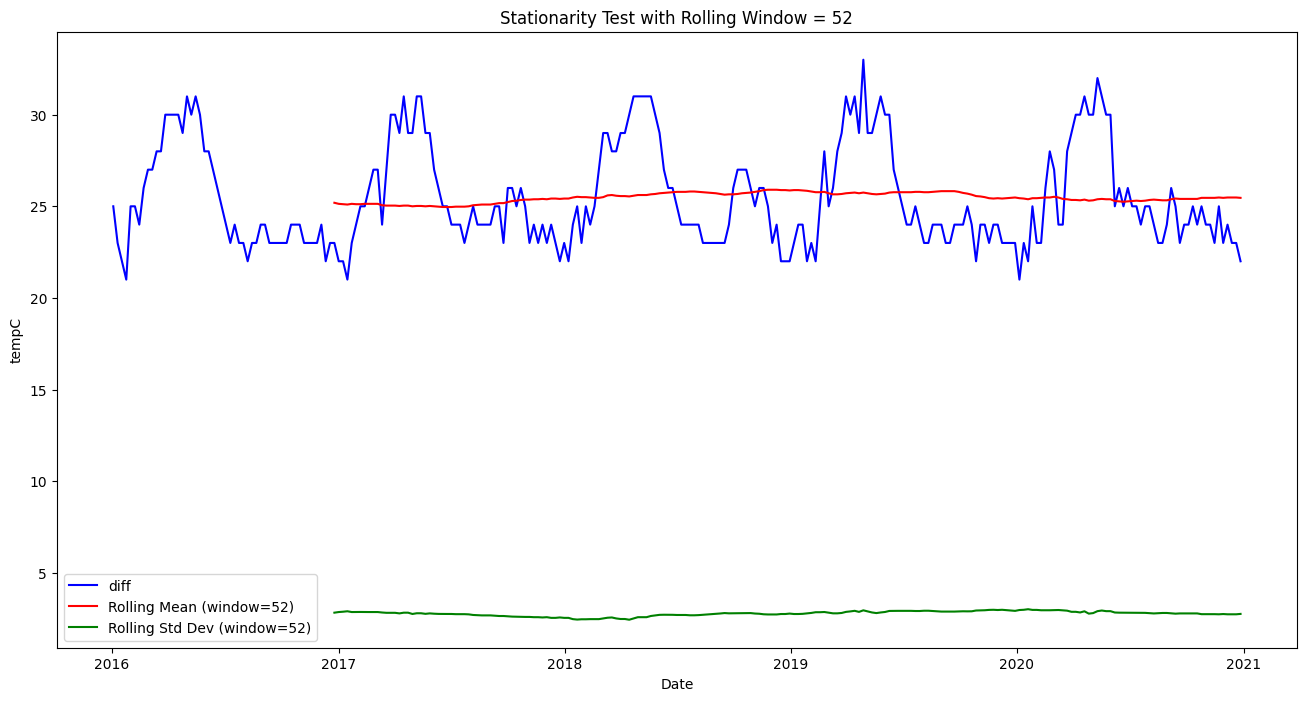

In [30]:
test_stationarity(Train_avg, "tempC", 52)

In [31]:
Train_avg["one_time_diff"] = Train_avg["tempC"].diff()  #one time difference

The p-value is: 3.1461651826640634e-08


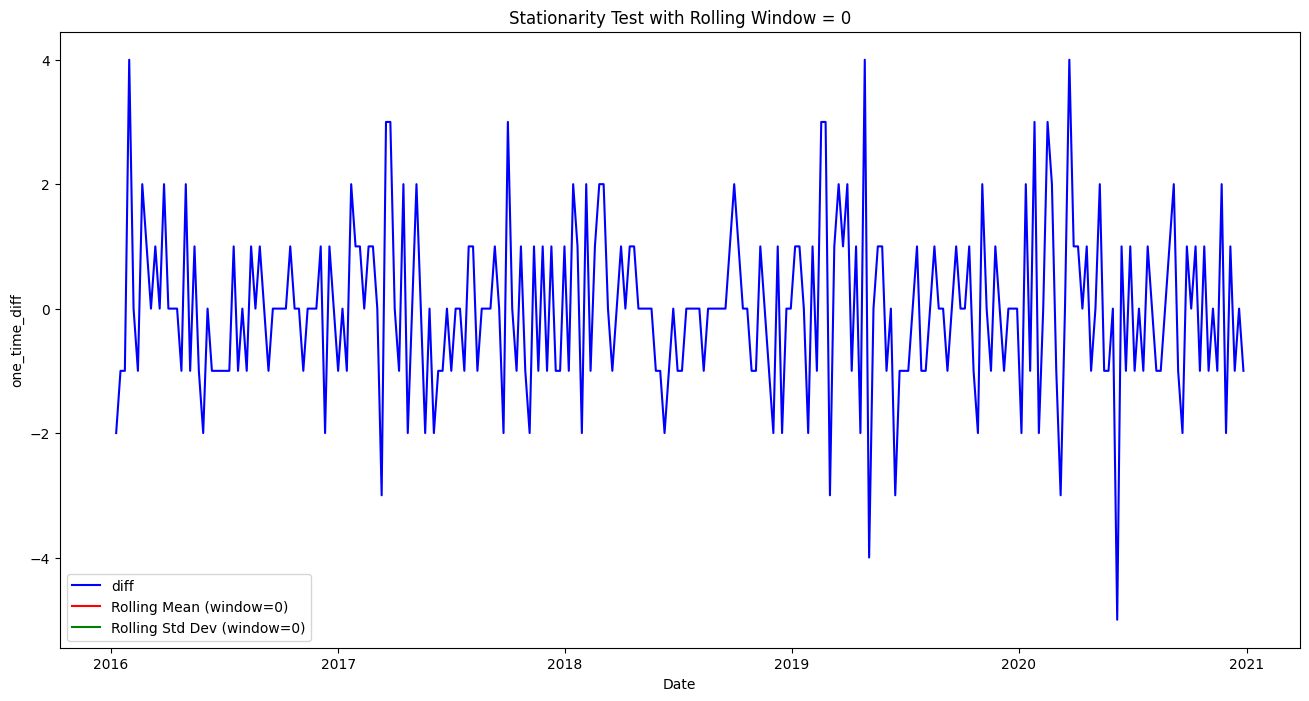

In [32]:
test_stationarity(Train_avg, "one_time_diff", 0)

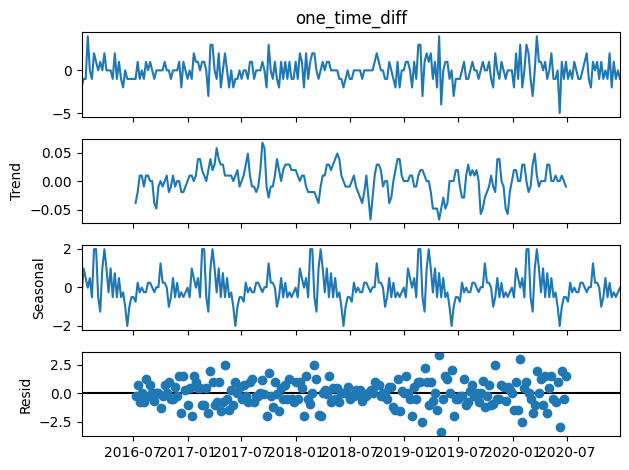

In [33]:
#plotting decomposed time series
s_decompose = seasonal_decompose(Train_avg['one_time_diff'].dropna(), model='additive', period=52)
s_decompose.plot()
plt.show()

The p-value is: 3.1461651826640634e-08


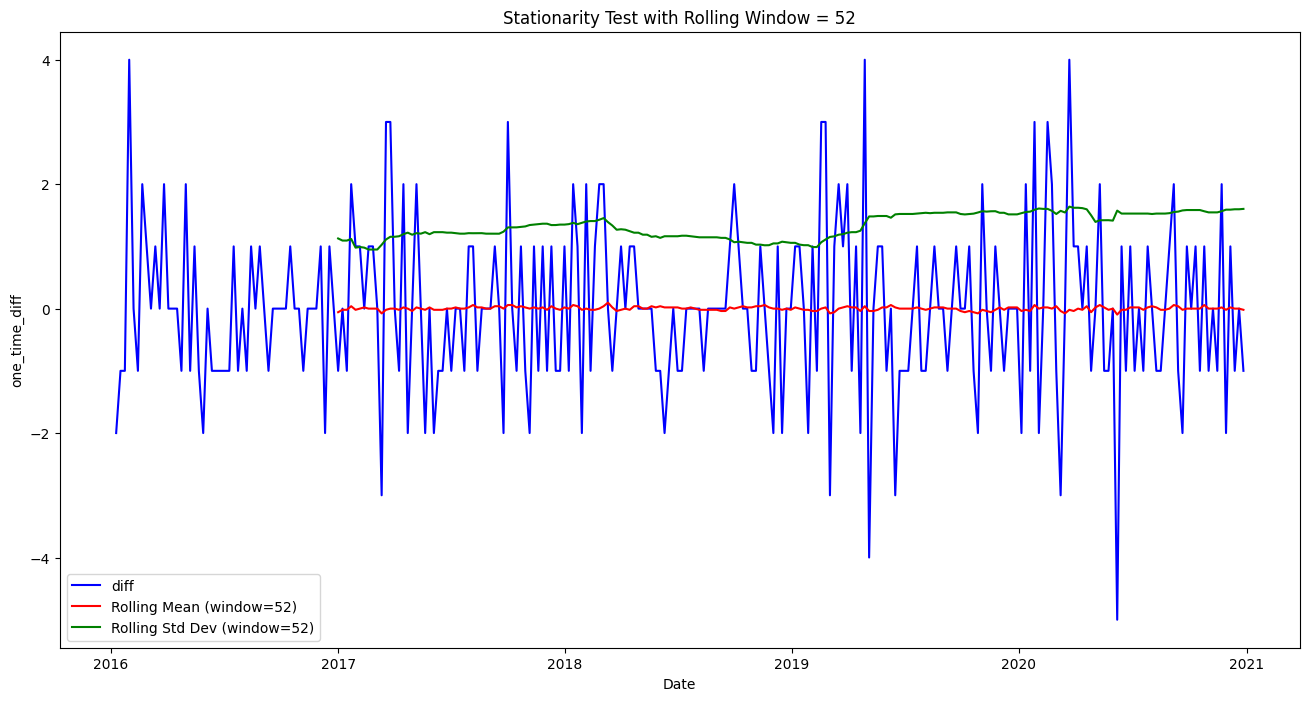

In [34]:
test_stationarity(Train_avg, "one_time_diff", 52)

From above graph and p-value we can confirm that the time series is stationary. We don't need to perform any transformations.

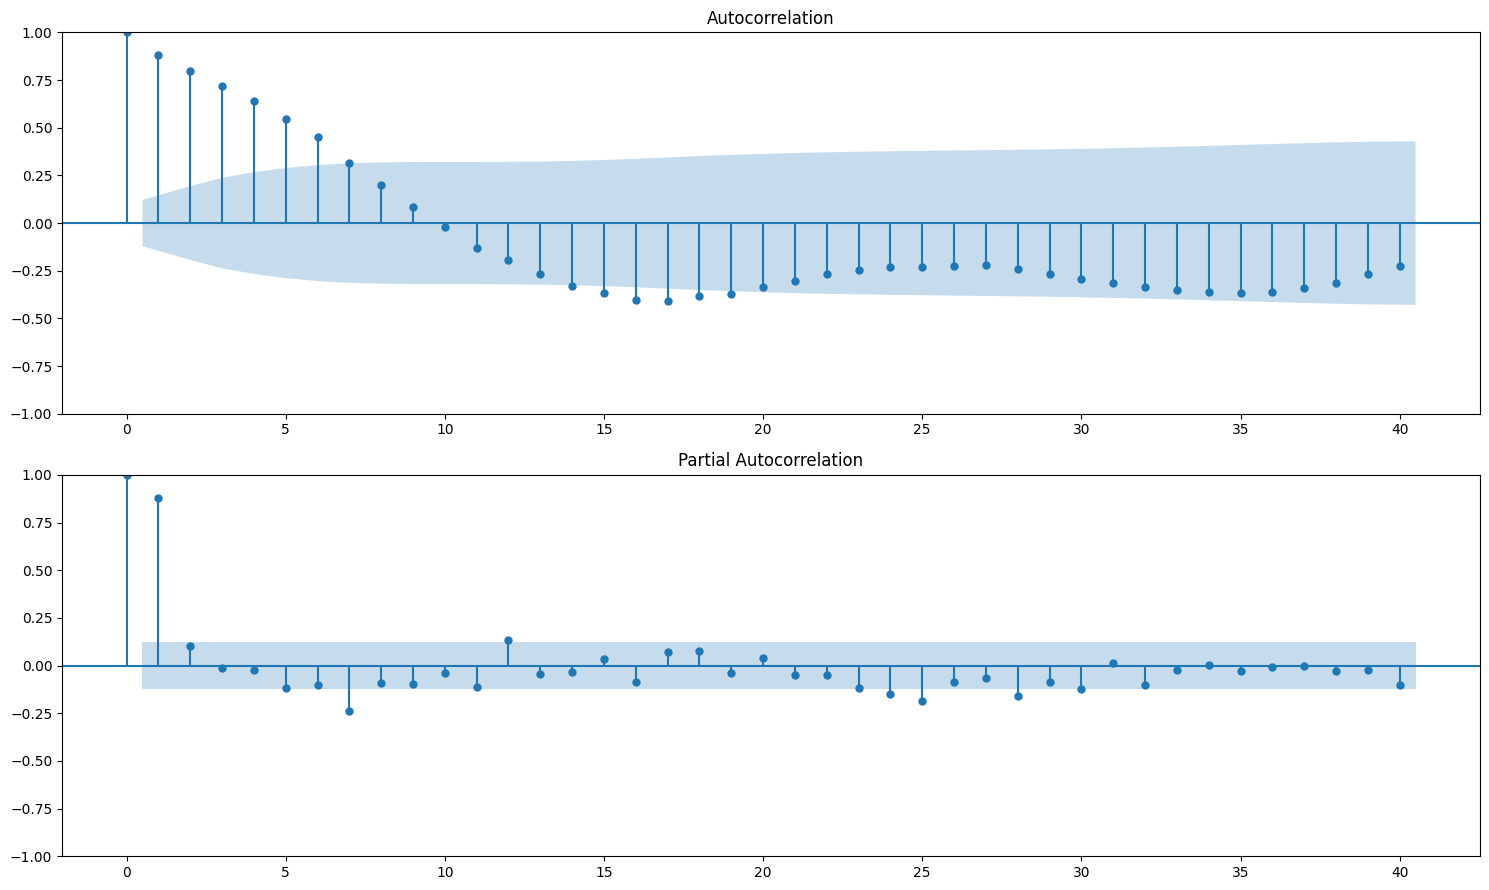

In [35]:
# plotting ACF and PACF
plt.figure(figsize=(15,9))

# Plot ACF
plt.subplot(2,1,1)
plot_acf(Train_avg['tempC'].dropna(), ax=plt.gca(), lags=40)

# Plot PACF
plt.subplot(2,1,2)
plot_pacf(Train_avg['tempC'].dropna(), ax=plt.gca(), lags=40)

# Show the plots
plt.tight_layout()
plt.show()

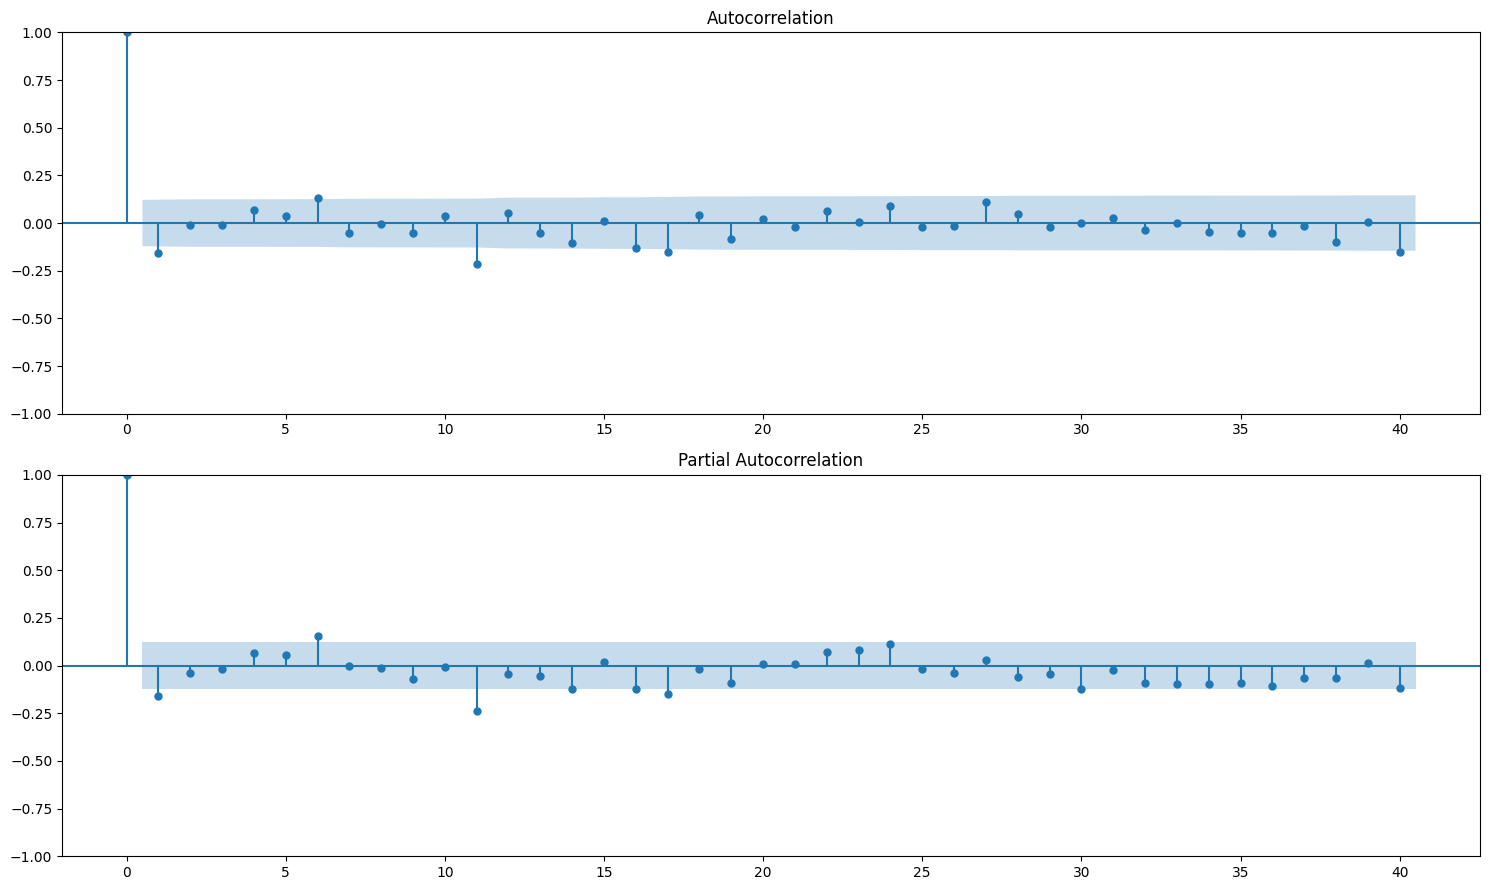

In [36]:
# plotting ACF and PACF
plt.figure(figsize=(15,9))

# Plot ACF
plt.subplot(2,1,1)
plot_acf(Train_avg['one_time_diff'].dropna(), ax=plt.gca(), lags=40)

# Plot PACF
plt.subplot(2,1,2)
plot_pacf(Train_avg['one_time_diff'].dropna(), ax=plt.gca(), lags=40)

# Show the plots
plt.tight_layout()
plt.show()

From above plots by looking at Partial Autocorrelation we choose p=1 or 11 Autocorrelation q=1 or 11 and as there was no differencing d=1

#### Creating Arima and Sarimax for Average temp. data

In [37]:
#using arima model to predict avg temperature
ar_model_1 = ARIMA(Train_avg["tempC"], order=(1, 1, 1))
ar_model_1 = ar_model_1.fit()

In [38]:
ar_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  tempC   No. Observations:                  261
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -440.468
Date:                Mon, 30 Sep 2024   AIC                            886.936
Time:                        07:37:56   BIC                            897.618
Sample:                    01-03-2016   HQIC                           891.230
                         - 12-27-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0318      0.339      0.094      0.925      -0.633       0.697
ma.L1         -0.1970      0.341     -0.578      0.563      -0.865       0.471
sigma2         1.7336      0.130     13.365      0.000       1.479       1.988
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 9.40
Prob(Q):                              0.98   Prob(JB):                         0.01
Heteroskedasticity (H):               1.34   Skew:                             0.17
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
ar_prediction_1 = ar_model_1.predict(start=Test_avg.index[0], end=Test_avg.index[-1])

In [40]:
Test_avg["ARIMA_pred"] = round(ar_prediction_1)

In [41]:
Test_avg.head()

maxtempC  mintempC  tempC  ARIMA_pred
date_time                                        
2021-01-03      31.0      17.0   24.0        22.0
2021-01-10      30.0      19.0   24.0        22.0
2021-01-17      31.0      20.0   25.0        22.0
2021-01-24      33.0      20.0   26.0        22.0
2021-01-31      33.0      19.0   25.0        22.0

In [42]:
#using evaluation metrics to check the performance of model
mse = mean_squared_error(Test_avg["tempC"], Test_avg["ARIMA_pred"])

In [43]:
arima_error = np.sqrt(mse)
arima_error

4.244863710948598

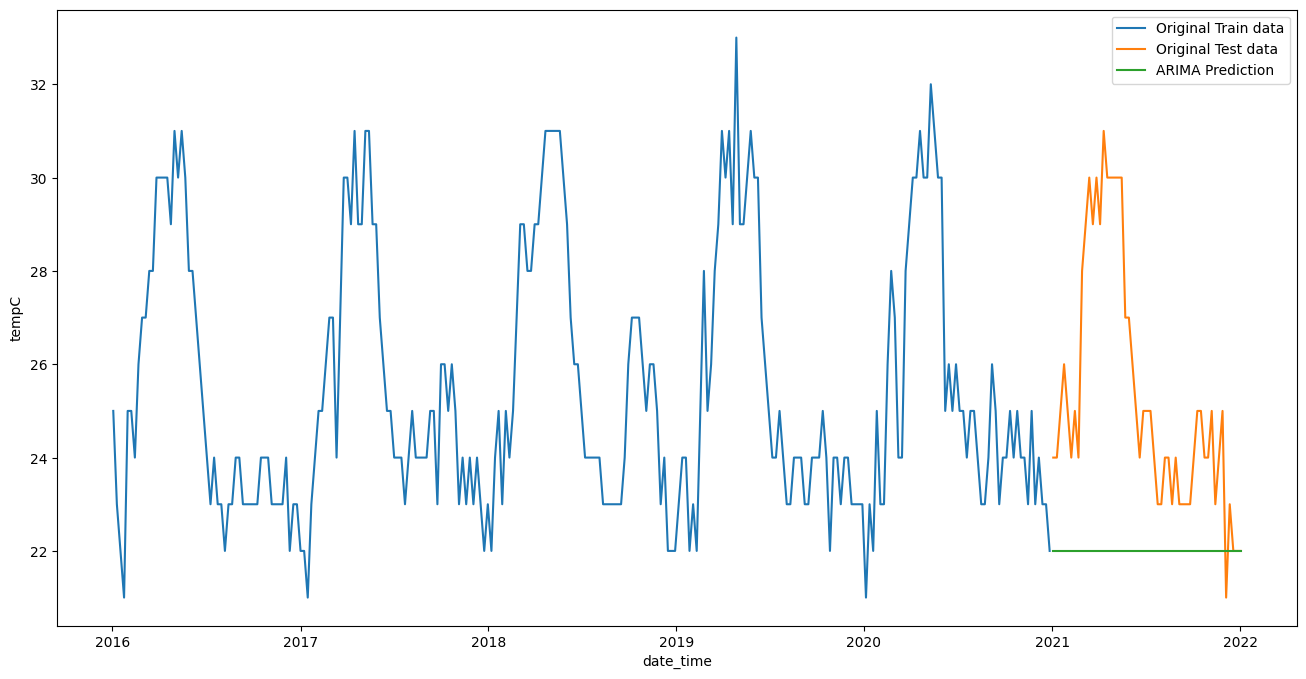

In [44]:
#plotting the arima predict with original data
plt.figure(figsize=(16, 8))

sns.lineplot(data=Train_avg, x='date_time', y='tempC', label="Original Train data")
sns.lineplot(data=Test_avg, x='date_time', y='tempC', label="Original Test data")
sns.lineplot(data=Test_avg, x='date_time', y='ARIMA_pred', label="ARIMA Prediction")

plt.show()

In [45]:
#using sarimax to predict
sar_model = SARIMAX(Train_avg["tempC"], order=(1,1,1), seasonal_order=(1, 1, 1, 52))
sar_model = sar_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [46]:
sar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              tempC   No. Observations:                  261
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -342.670
Date:                            Mon, 30 Sep 2024   AIC                            695.340
Time:                                    07:38:42   BIC                            712.027
Sample:                                01-03-2016   HQIC                           702.087
                                     - 12-27-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3437      0.069      4.958      0.000       0.208       0.479
ma.L1         -0.9642      0.026    -37.013      0.000      -1.015      -0.913
ar.S.L52      -0.0414      0.162     -0.256      0.798      -0.358       0.275
ma.S.L52      -0.9964     25.585     -0.039      0.969     -51.142      49.150
sigma2         1.0315     26.255      0.039      0.969     -50.428      52.491
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.38
Prob(Q):                              0.94   Prob(JB):                         0.18
Heteroskedasticity (H):               1.03   Skew:                            -0.30
Prob(H) (two-sided):                  0.91   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
sar_prediction = sar_model.predict(start=Test_avg.index[0], end=Test_avg.index[-1])

In [48]:
Test_avg["SARIMAX_pred"] = round(sar_prediction)

In [49]:
mse = mean_squared_error(Test_avg["tempC"], Test_avg["SARIMAX_pred"])
mse

1.679245283018868

In [50]:
rmse = np.sqrt(mse)
rmse

1.2958569685805867

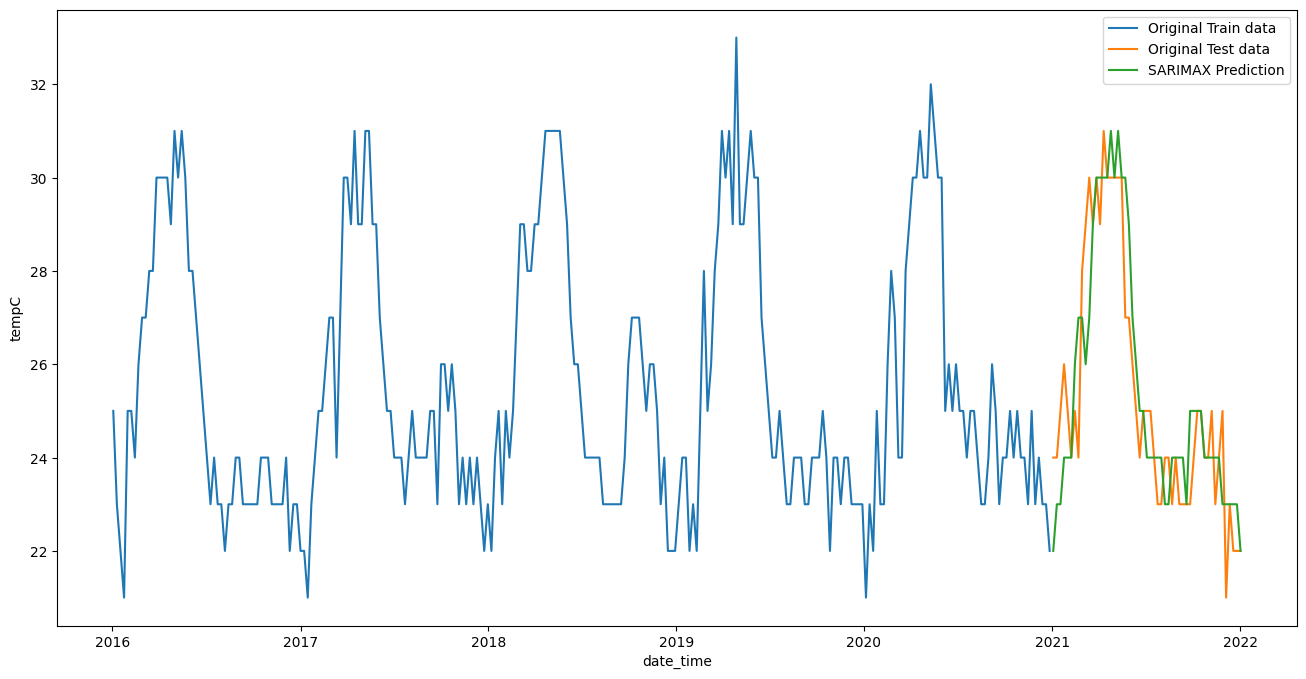

In [51]:
# plotting the sarimax predict and original data
plt.figure(figsize=(16, 8))

sns.lineplot(data=Train_avg, x='date_time', y='tempC', label="Original Train data")
sns.lineplot(data=Test_avg, x='date_time', y='tempC', label="Original Test data")
sns.lineplot(data=Test_avg, x='date_time', y='SARIMAX_pred', label="SARIMAX Prediction")

plt.show()

In [52]:
# creating future time data to predict the future values
future_dates = pd.date_range(start="2022-01-01", end="2025-12-31")
new_data = pd.DataFrame(future_dates, columns=['date_time'])
new_data.set_index('date_time', inplace=True)

In [53]:
new_data = new_data.resample('W').mean()  # Resample to weekly data

In [54]:
new_data["avg_temp_pred"] = sar_model.predict(start=new_data.index[0], end=new_data.index[-1])

In [55]:
new_data['avg_temp_pred'] = round(new_data['avg_temp_pred'])

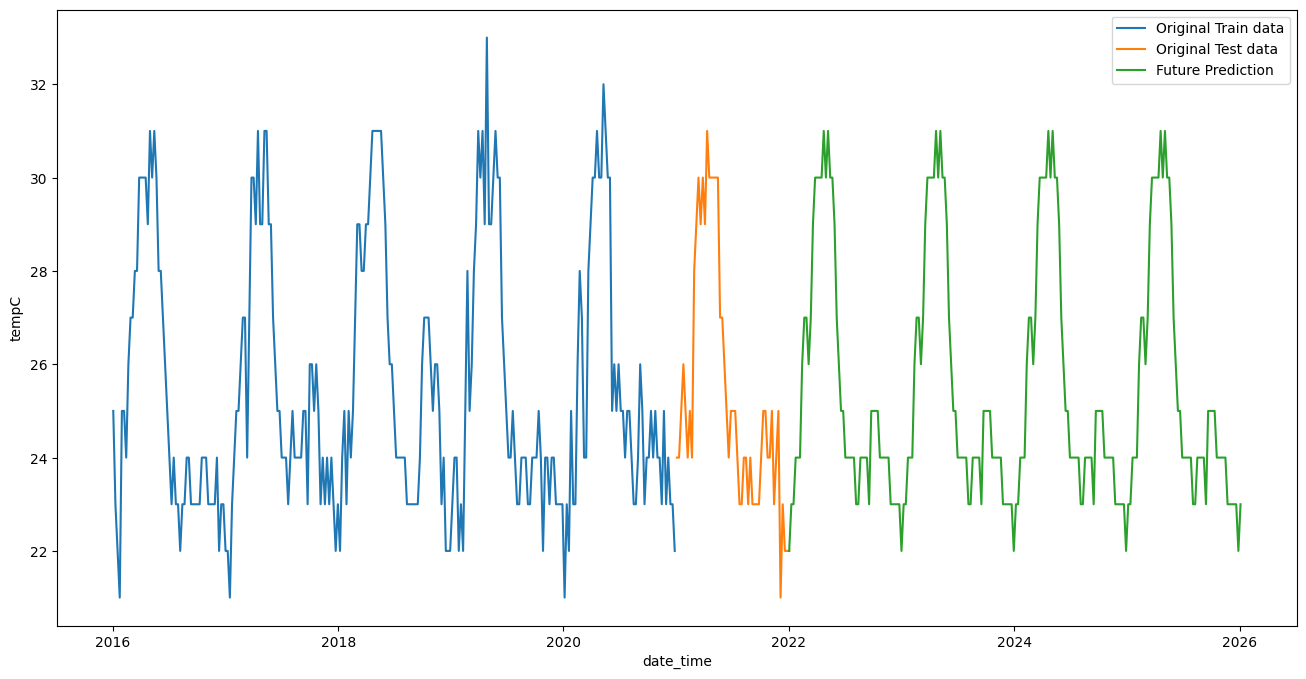

In [56]:
#plotting the original and predicted data
plt.figure(figsize=(16, 8))

sns.lineplot(data=Train_avg, x='date_time', y='tempC', label="Original Train data")
sns.lineplot(data=Test_avg, x='date_time', y='tempC', label="Original Test data")
sns.lineplot(data=new_data, x='date_time', y='avg_temp_pred', label="Future Prediction")

plt.show()

### Solving for Minimum Temperature

In [57]:
#creating training and testing datasets for min temp

Train_min = df.iloc[:261, :].copy()

Test_min = df.iloc[261:, :].copy()

In [58]:
Test_min.head()

maxtempC  mintempC  tempC
date_time                            
2021-01-03      31.0      17.0   24.0
2021-01-10      30.0      19.0   24.0
2021-01-17      31.0      20.0   25.0
2021-01-24      33.0      20.0   26.0
2021-01-31      33.0      19.0   25.0

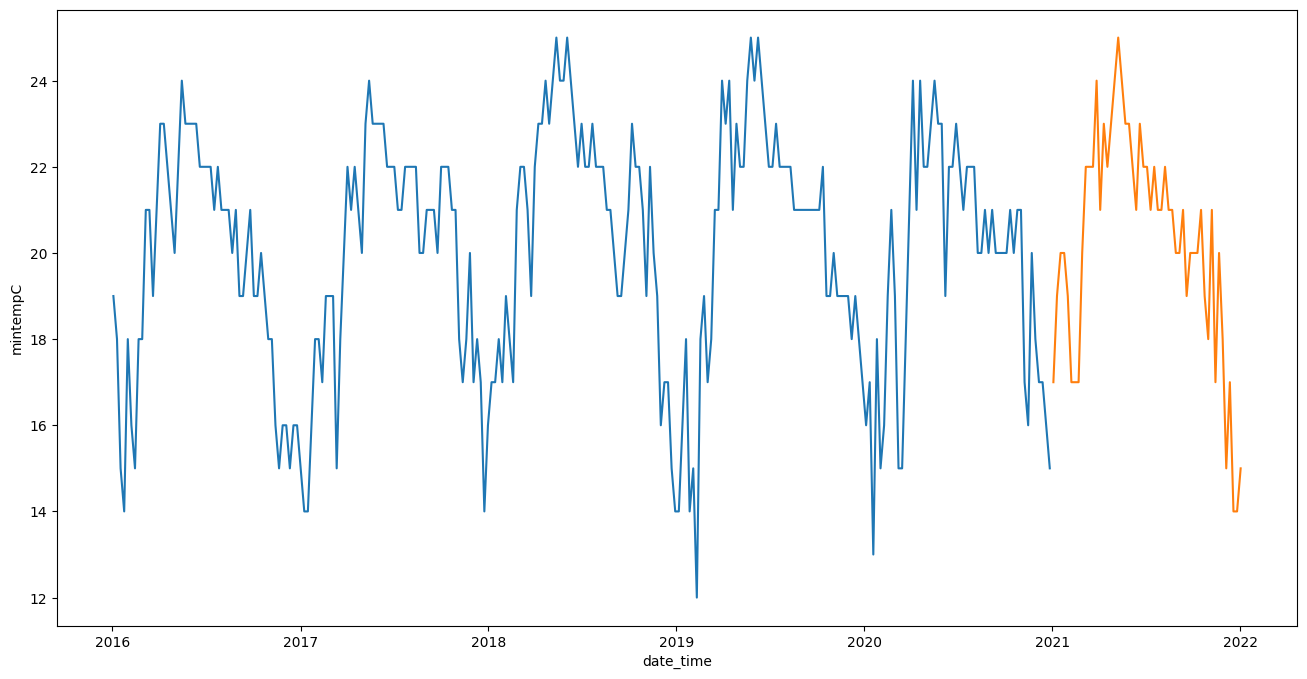

In [59]:
plt.figure(figsize=(16, 8))

sns.lineplot(data=Train_min, x='date_time', y='mintempC')
sns.lineplot(data=Test_min, x='date_time', y='mintempC')

plt.show()

The p-value is: 4.363840388485566e-05


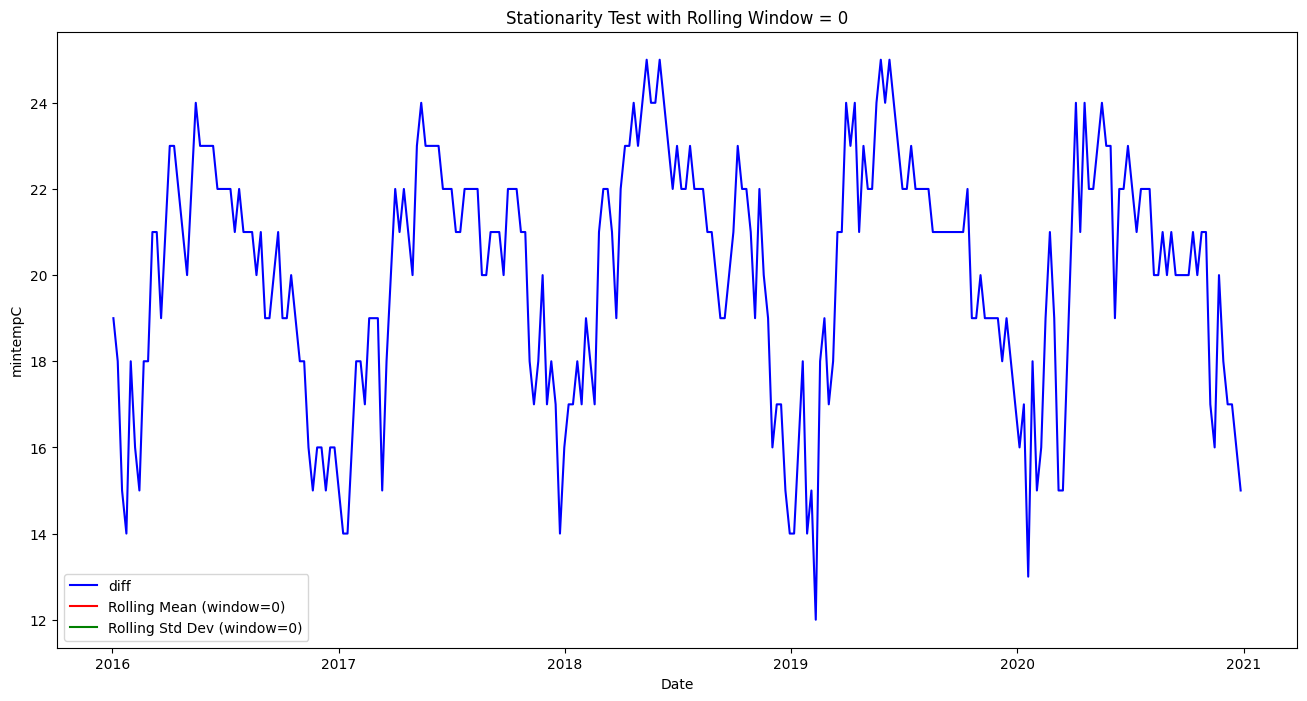

In [60]:
test_stationarity(Train_min, "mintempC", 0)

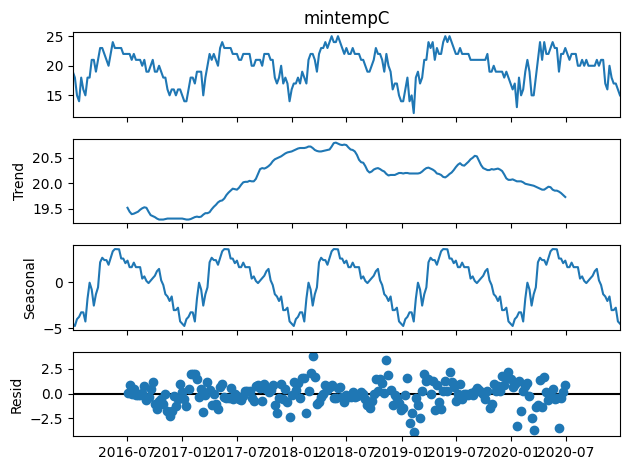

In [61]:
#plotting decomposed time series
s_decompose = seasonal_decompose(Train_min['mintempC'], model='additive', period=52)
s_decompose.plot()
plt.show()

The p-value is: 4.363840388485566e-05


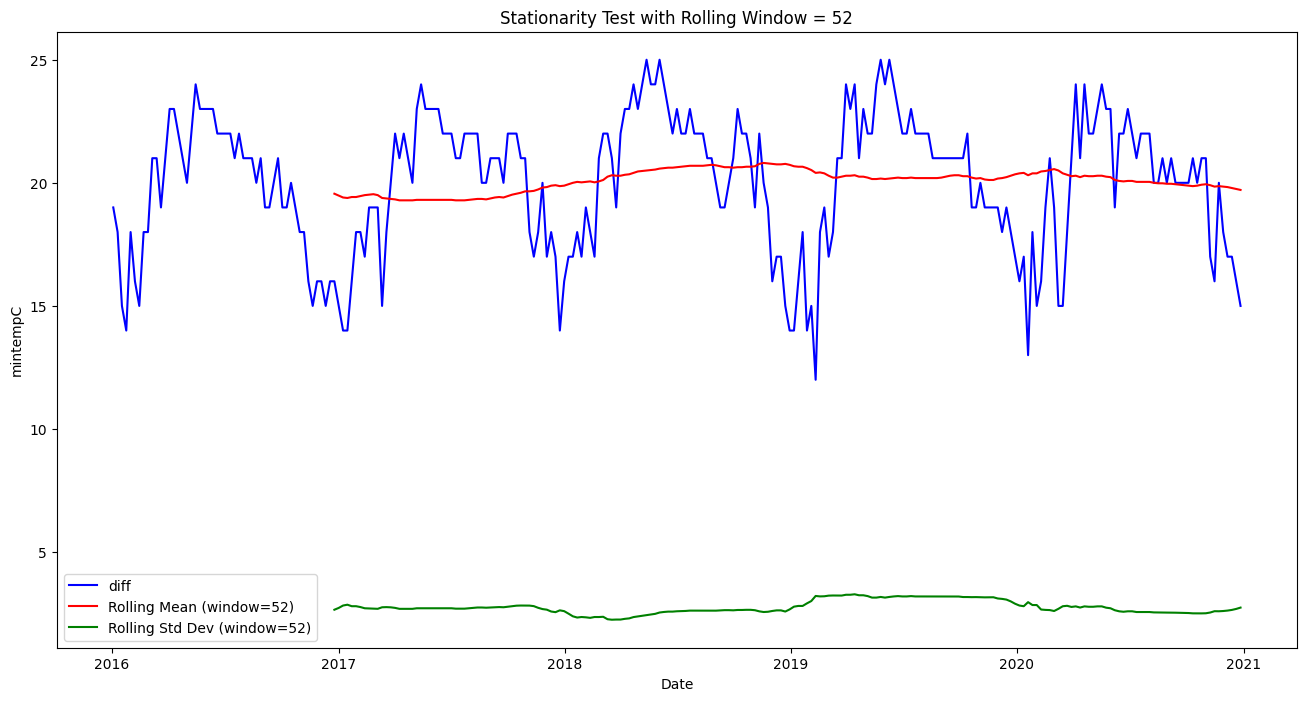

In [62]:
test_stationarity(Train_min, "mintempC", 52)

In [63]:
Train_min["one_time_diff"] = Train_min["mintempC"].diff()

The p-value is: 0.0003437498401157486


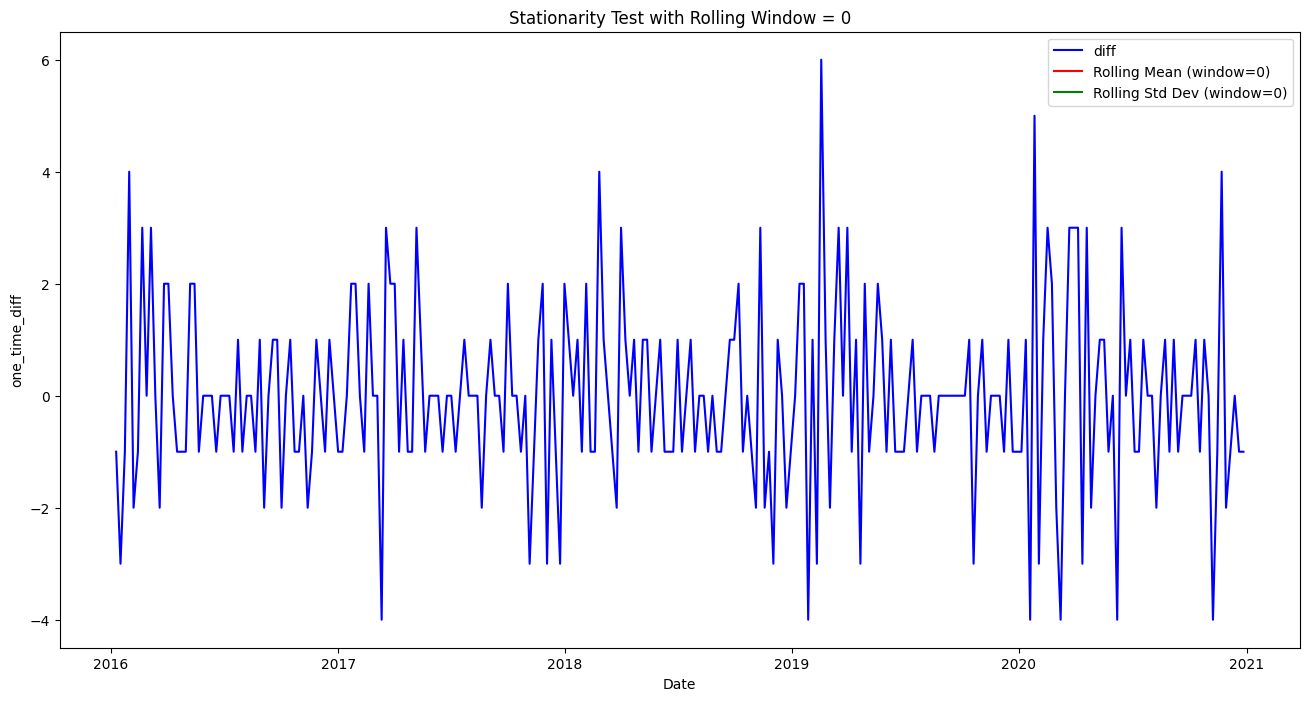

In [64]:
test_stationarity(Train_min, "one_time_diff", 0)

The p-value is: 0.0003437498401157486


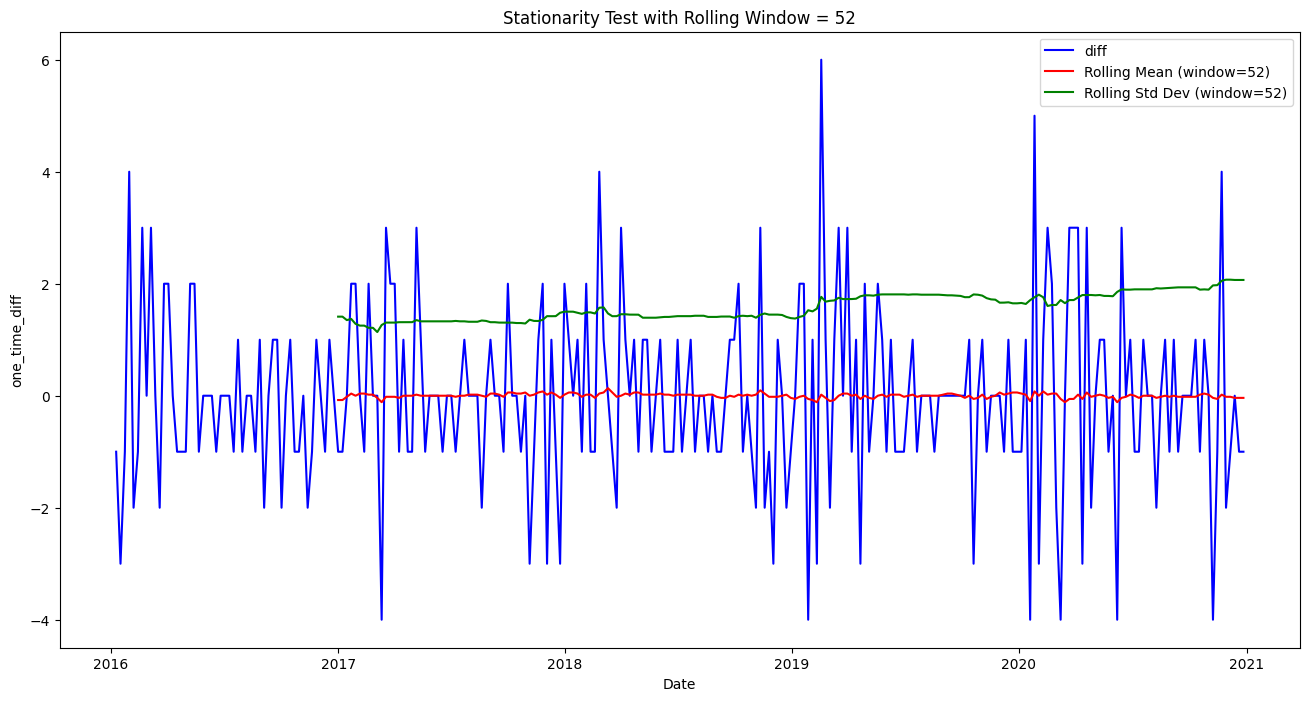

In [65]:
test_stationarity(Train_min, "one_time_diff", 52)

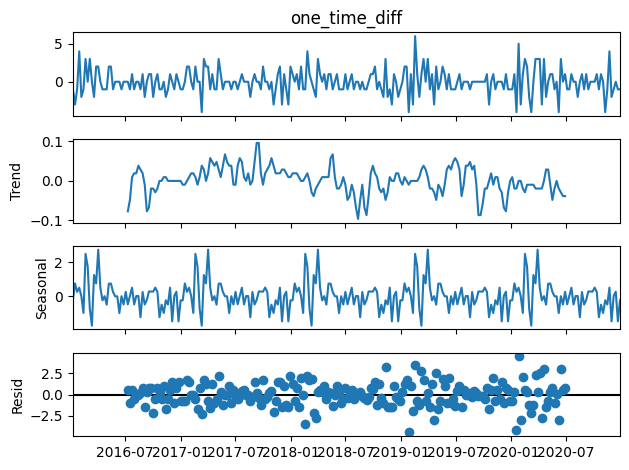

In [66]:
#plotting decomposed time series
s_decompose = seasonal_decompose(Train_min['one_time_diff'].dropna(), model='additive', period=52)
s_decompose.plot()
plt.show()

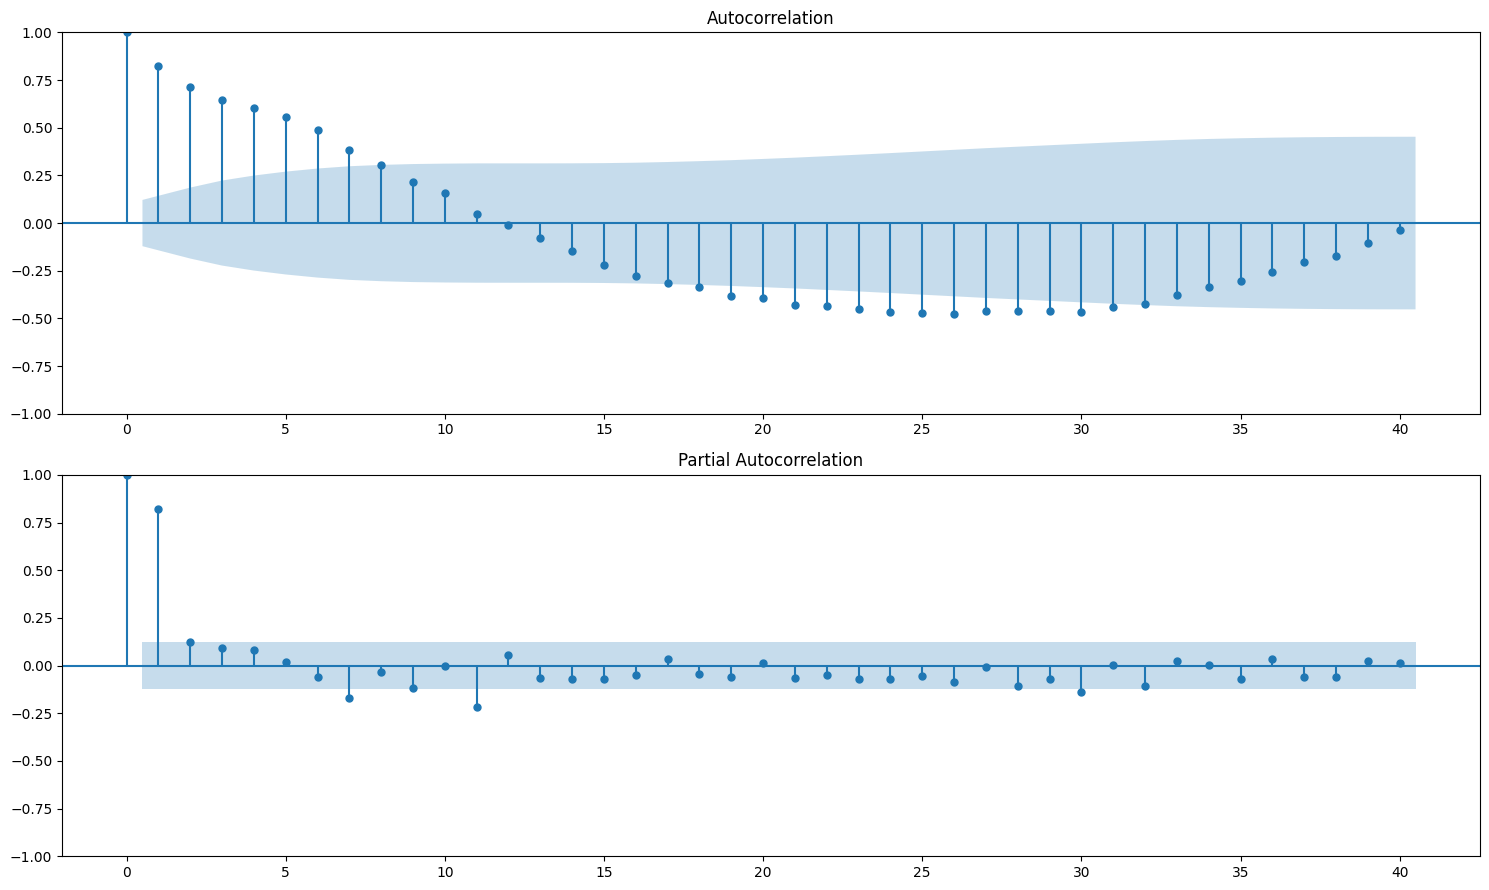

In [67]:
plt.figure(figsize=(15,9))

# Plot ACF
plt.subplot(2,1,1)
plot_acf(Train_min['mintempC'].dropna(), ax=plt.gca(), lags=40)

# Plot PACF
plt.subplot(2,1,2)
plot_pacf(Train_min['mintempC'].dropna(), ax=plt.gca(), lags=40)

# Show the plots
plt.tight_layout()
plt.show()

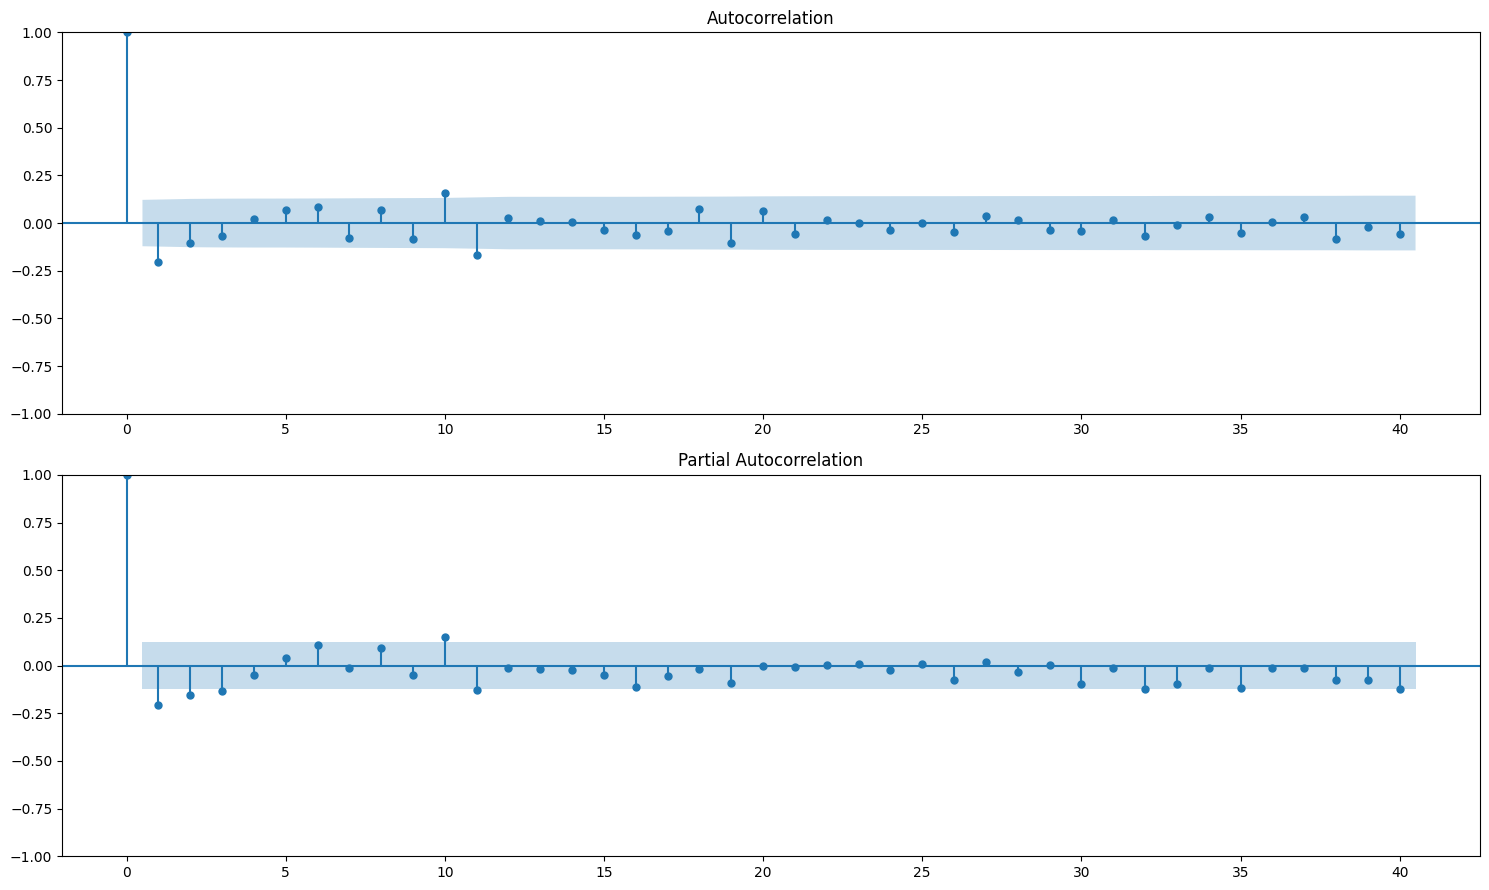

In [68]:
plt.figure(figsize=(15,9))

# Plot ACF
plt.subplot(2,1,1)
plot_acf(Train_min['one_time_diff'].dropna(), ax=plt.gca(), lags=40)

# Plot PACF
plt.subplot(2,1,2)
plot_pacf(Train_min['one_time_diff'].dropna(), ax=plt.gca(), lags=40)

# Show the plots
plt.tight_layout()
plt.show()

#### Creating Arima and Sarimax for Minimum temp. data

In [69]:
ar_model_2 = ARIMA(Train_min["mintempC"], order=(1, 1, 1))
ar_model_2 = ar_model_2.fit()

In [70]:
ar_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               mintempC   No. Observations:                  261
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -482.278
Date:                Mon, 30 Sep 2024   AIC                            970.555
Time:                        07:38:52   BIC                            981.237
Sample:                    01-03-2016   HQIC                           974.849
                         - 12-27-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2892      0.152      1.897      0.058      -0.010       0.588
ma.L1         -0.5628      0.138     -4.067      0.000      -0.834      -0.292
sigma2         2.3905      0.185     12.910      0.000       2.028       2.753
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 6.11
Prob(Q):                              0.81   Prob(JB):                         0.05
Heteroskedasticity (H):               1.34   Skew:                             0.21
Prob(H) (two-sided):                  0.17   Kurtosis:                         3.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [71]:
ar_prediction_2 = ar_model_2.predict(start=Test_min.index[0], end=Test_min.index[-1])

In [72]:
Test_min["ARIMA_pred"] = round(ar_prediction_2)

In [73]:
Test_min.head()

maxtempC  mintempC  tempC  ARIMA_pred
date_time                                        
2021-01-03      31.0      17.0   24.0        15.0
2021-01-10      30.0      19.0   24.0        16.0
2021-01-17      31.0      20.0   25.0        16.0
2021-01-24      33.0      20.0   26.0        16.0
2021-01-31      33.0      19.0   25.0        16.0

In [74]:
mse = mean_squared_error(Test_min["mintempC"], Test_min["ARIMA_pred"])
mse

24.50943396226415

In [75]:
rmse = np.sqrt(mse)
rmse

4.950700350684149

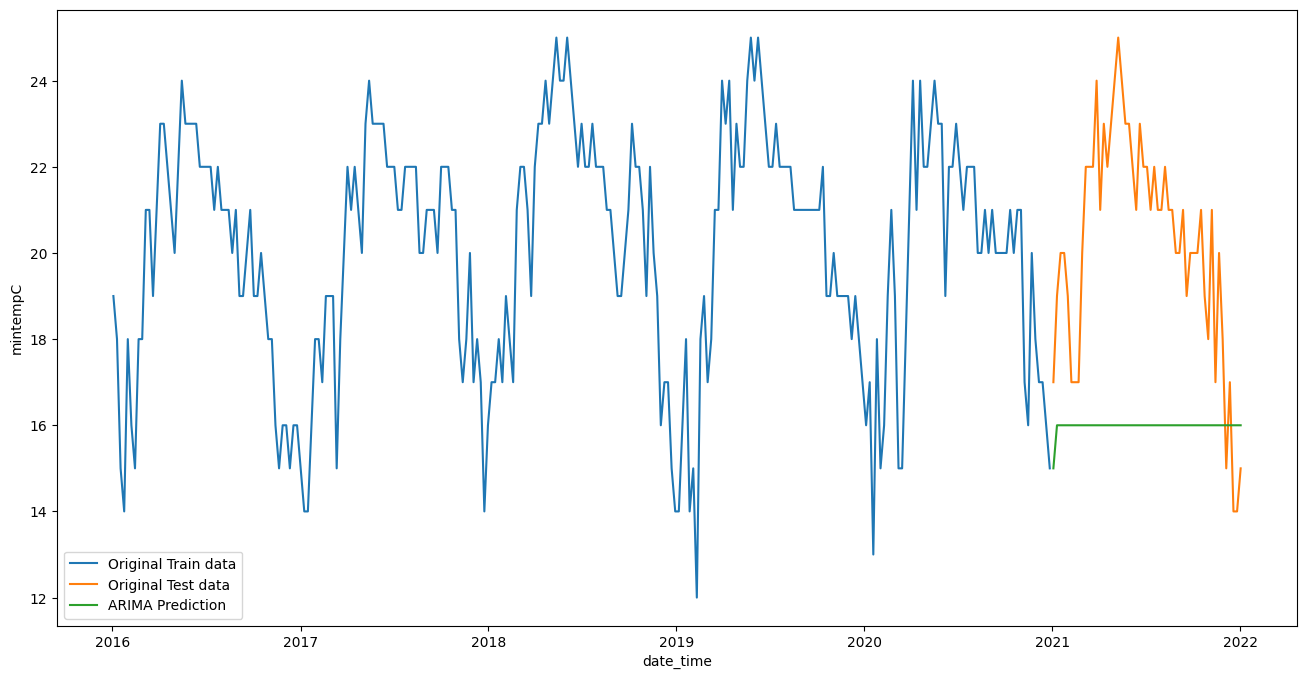

In [76]:
plt.figure(figsize=(16, 8))

sns.lineplot(data=Train_min, x='date_time', y='mintempC', label="Original Train data")
sns.lineplot(data=Test_min, x='date_time', y='mintempC', label="Original Test data")
sns.lineplot(data=Test_min, x='date_time', y='ARIMA_pred', label="ARIMA Prediction")

plt.show()

In [77]:
sar_model_2 = SARIMAX(Train_min["mintempC"], order=(1,1,1), seasonal_order=(1, 1, 1, 52))
sar_model_2 = sar_model_2.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [78]:
sar_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           mintempC   No. Observations:                  261
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -390.479
Date:                            Mon, 30 Sep 2024   AIC                            790.957
Time:                                    07:39:22   BIC                            807.645
Sample:                                01-03-2016   HQIC                           797.705
                                     - 12-27-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3325      0.072      4.599      0.000       0.191       0.474
ma.L1         -0.9327      0.030    -31.382      0.000      -0.991      -0.874
ar.S.L52      -0.0471      0.150     -0.313      0.754      -0.342       0.247
ma.S.L52      -0.9947     14.967     -0.066      0.947     -30.330      28.340
sigma2         1.6383     24.353      0.067      0.946     -46.093      49.370
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                30.06
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                            -0.69
Prob(H) (two-sided):                  0.44   Kurtosis:                         4.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [79]:
sar_prediction_2 = sar_model_2.predict(start=Test_min.index[0], end=Test_min.index[-1])

In [80]:
Test_min["SARIMAX_pred"] = round(sar_prediction_2)

In [81]:
mse_2 = mean_squared_error(Test_min["mintempC"], Test_min["SARIMAX_pred"])
mse_2

2.811320754716981

In [82]:
rmse_2 = np.sqrt(mse_2)
rmse_2

1.6766993632482183

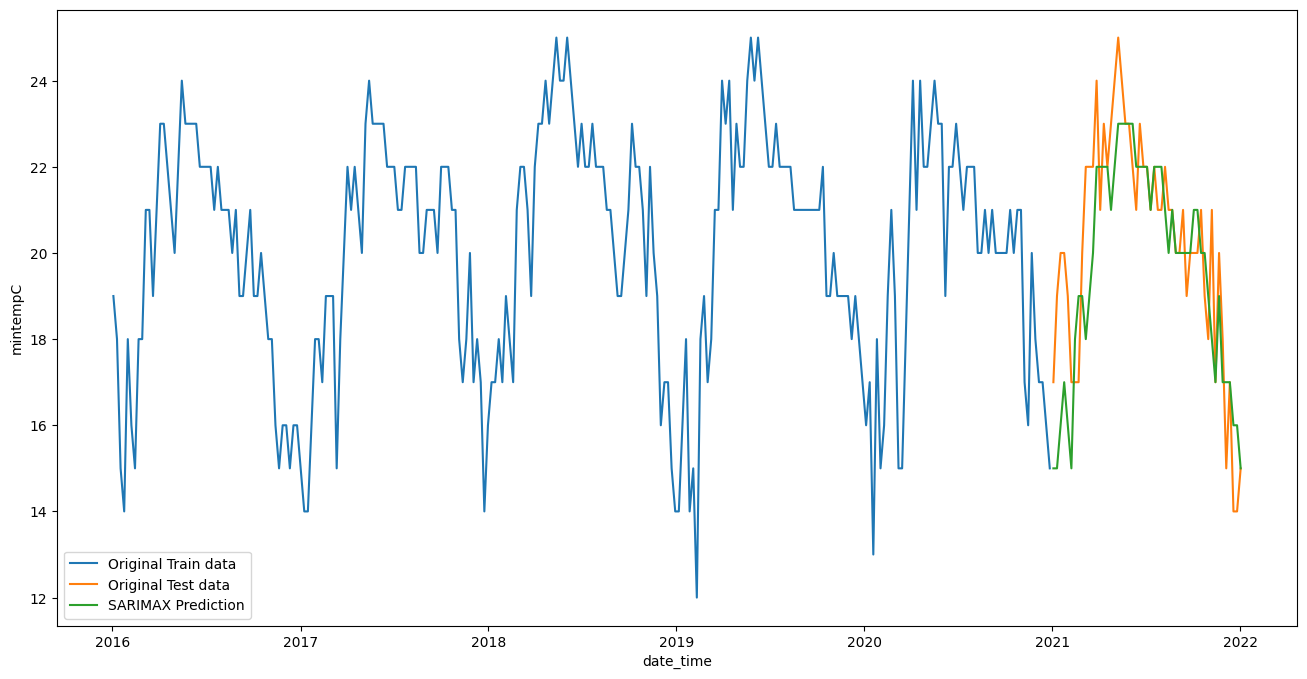

In [83]:
plt.figure(figsize=(16, 8))

sns.lineplot(data=Train_min, x='date_time', y='mintempC', label="Original Train data")
sns.lineplot(data=Test_min, x='date_time', y='mintempC', label="Original Test data")
sns.lineplot(data=Test_min, x='date_time', y='SARIMAX_pred', label="SARIMAX Prediction")

plt.show()

In [84]:
new_data["min_temp_pred"] = sar_model_2.predict(start=new_data.index[0], end=new_data.index[-1])

In [85]:
new_data["min_temp_pred"] = round(new_data["min_temp_pred"])

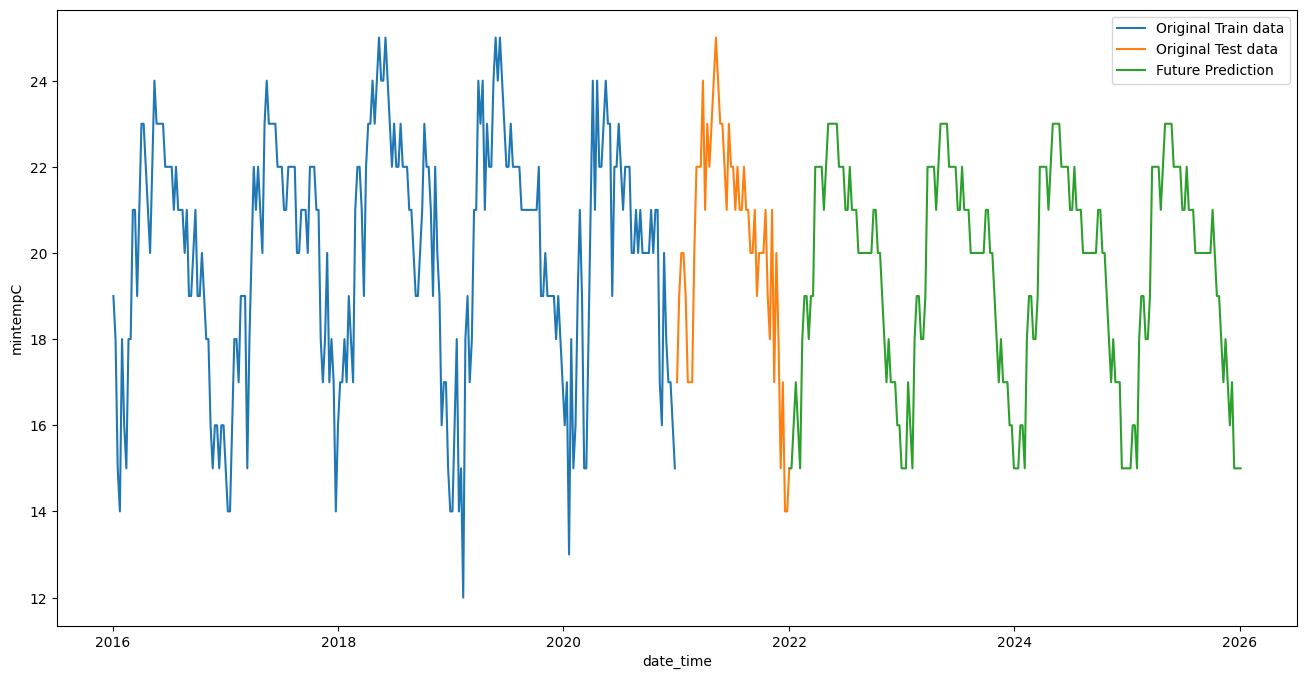

In [86]:
plt.figure(figsize=(16, 8))

sns.lineplot(data=Train_min, x='date_time', y='mintempC', label="Original Train data")
sns.lineplot(data=Test_min, x='date_time', y='mintempC', label="Original Test data")
sns.lineplot(data=new_data, x='date_time', y='min_temp_pred', label="Future Prediction")

plt.show()

### Solving for Maximum Temperature

In [87]:
#creating training and testing datasets for max temp

Train_max = df.iloc[:261, :].copy()

Test_max = df.iloc[261:, :].copy()

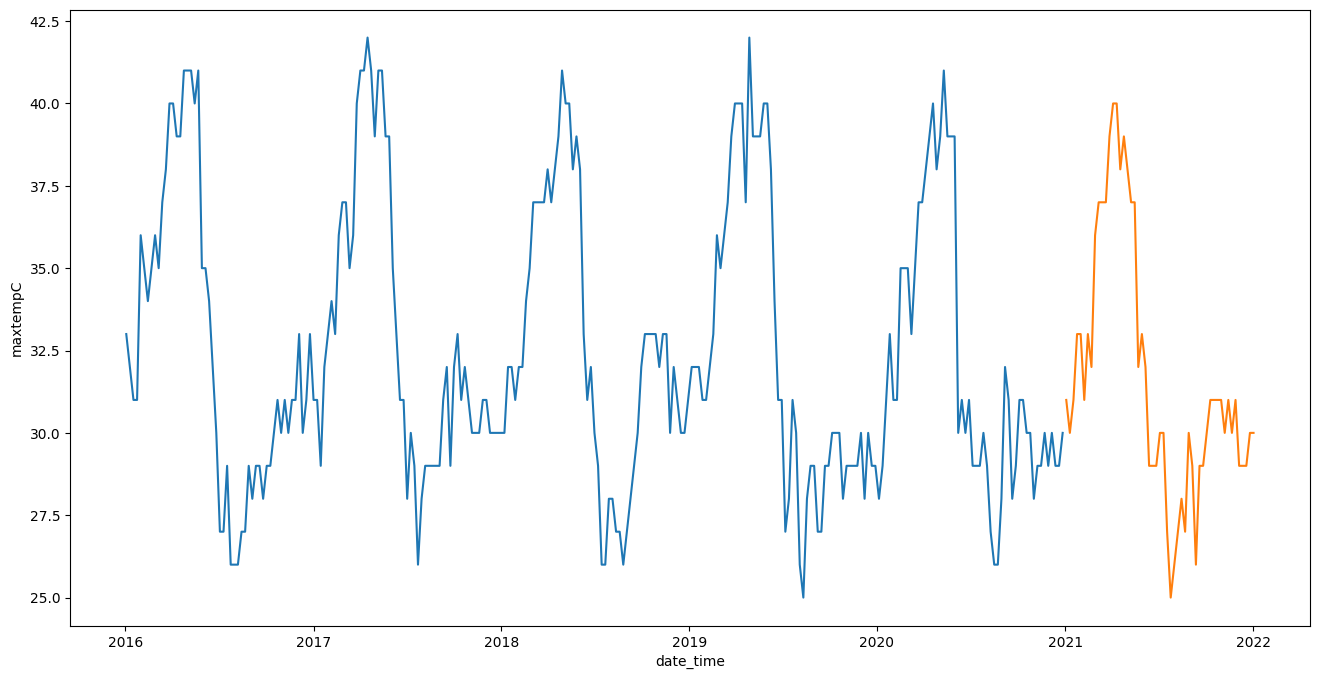

In [88]:
plt.figure(figsize=(16, 8))

sns.lineplot(data=Train_max, x='date_time', y='maxtempC')
sns.lineplot(data=Test_max, x='date_time', y='maxtempC')

plt.show()

The p-value is: 1.591033709337743e-06


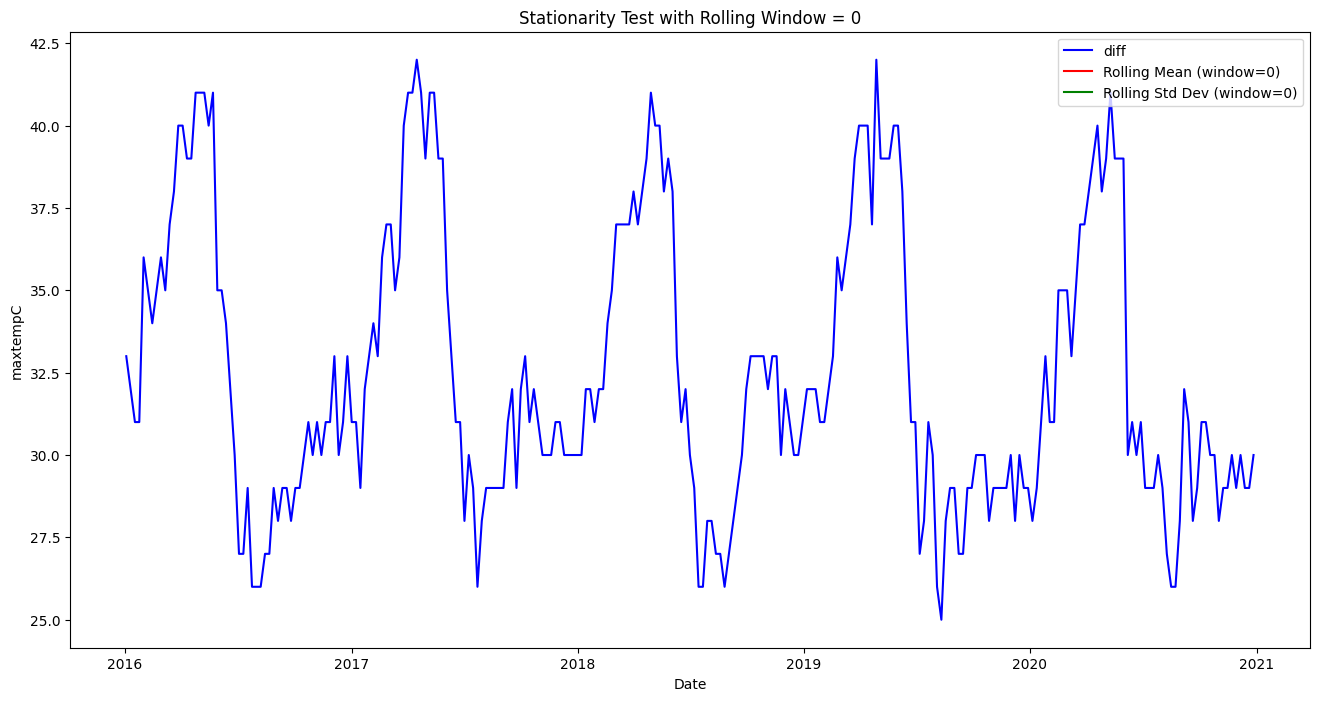

In [89]:
test_stationarity(Train_max, "maxtempC", 0)

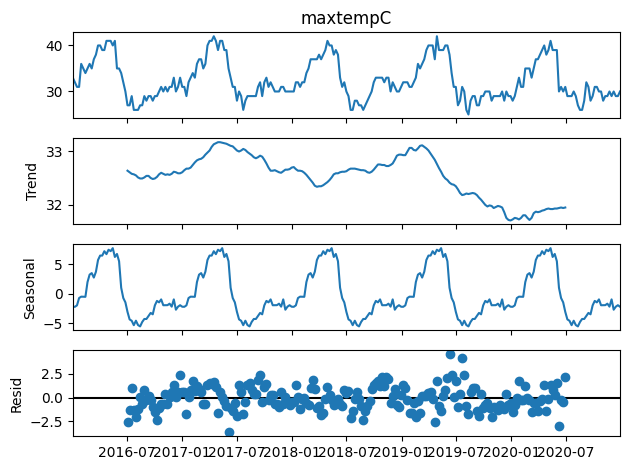

In [90]:
#plotting decomposed time series
s_decompose = seasonal_decompose(Train_max['maxtempC'], model='additive', period=52)
s_decompose.plot()
plt.show()

The p-value is: 1.591033709337743e-06


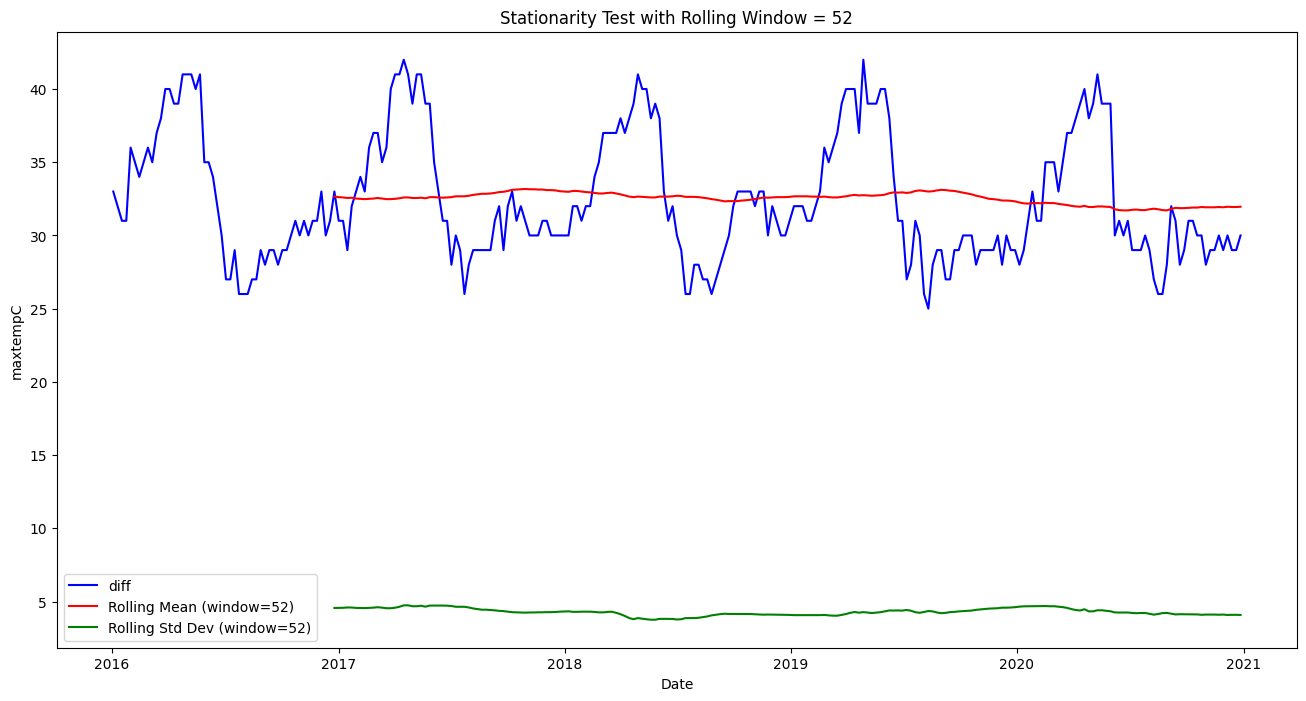

In [91]:
test_stationarity(Train_max, "maxtempC", 52)

In [92]:
Train_max["one_time_diff"] = Train_max["maxtempC"].diff()

The p-value is: 2.0804044841764006e-07


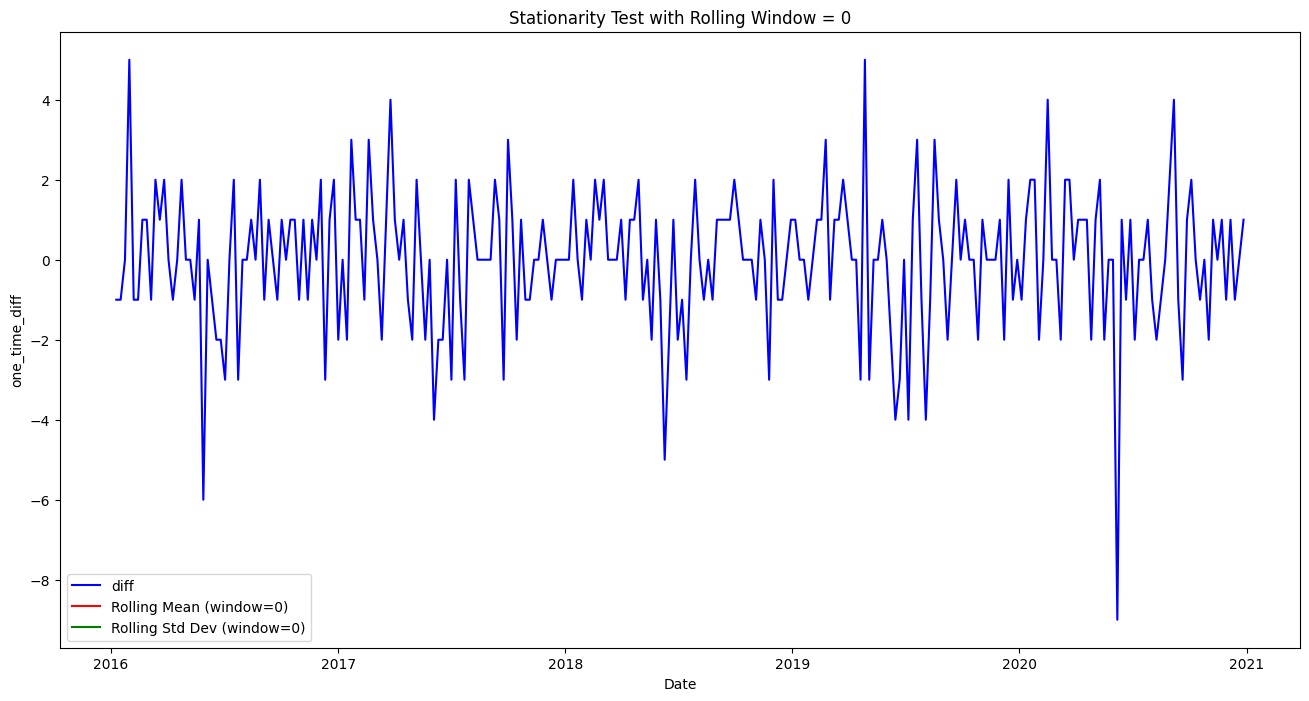

In [93]:
test_stationarity(Train_max, "one_time_diff", 0)

The p-value is: 2.0804044841764006e-07


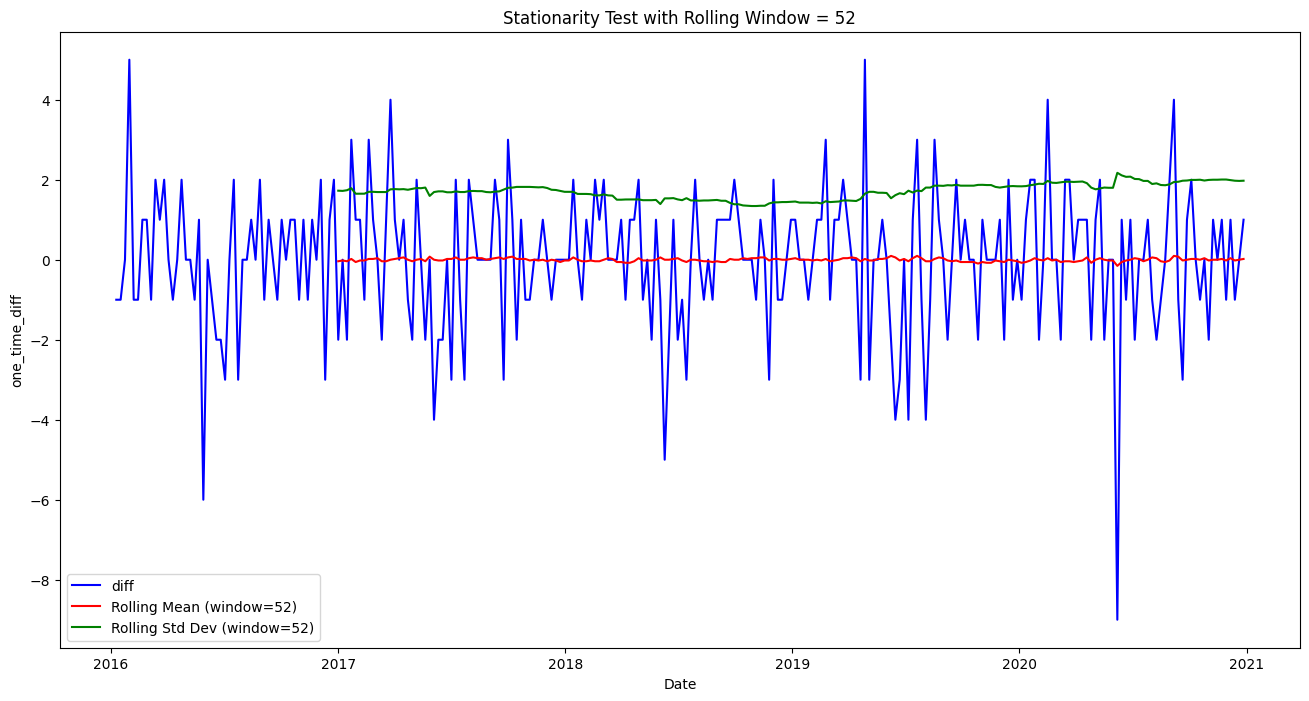

In [94]:
test_stationarity(Train_max, "one_time_diff", 52)

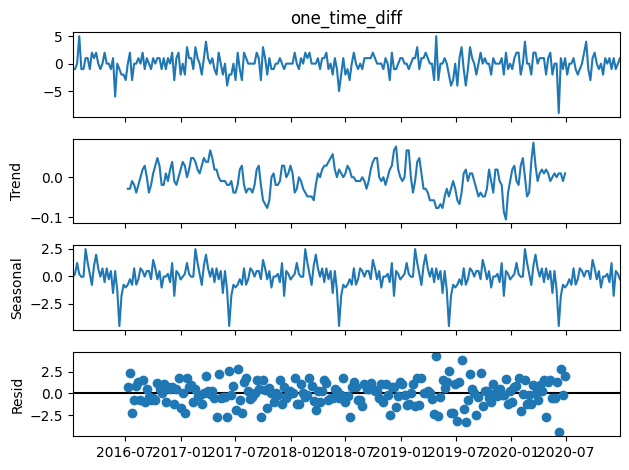

In [95]:
#plotting decomposed time series
s_decompose = seasonal_decompose(Train_max['one_time_diff'].dropna(), model='additive', period=52)
s_decompose.plot()
plt.show()

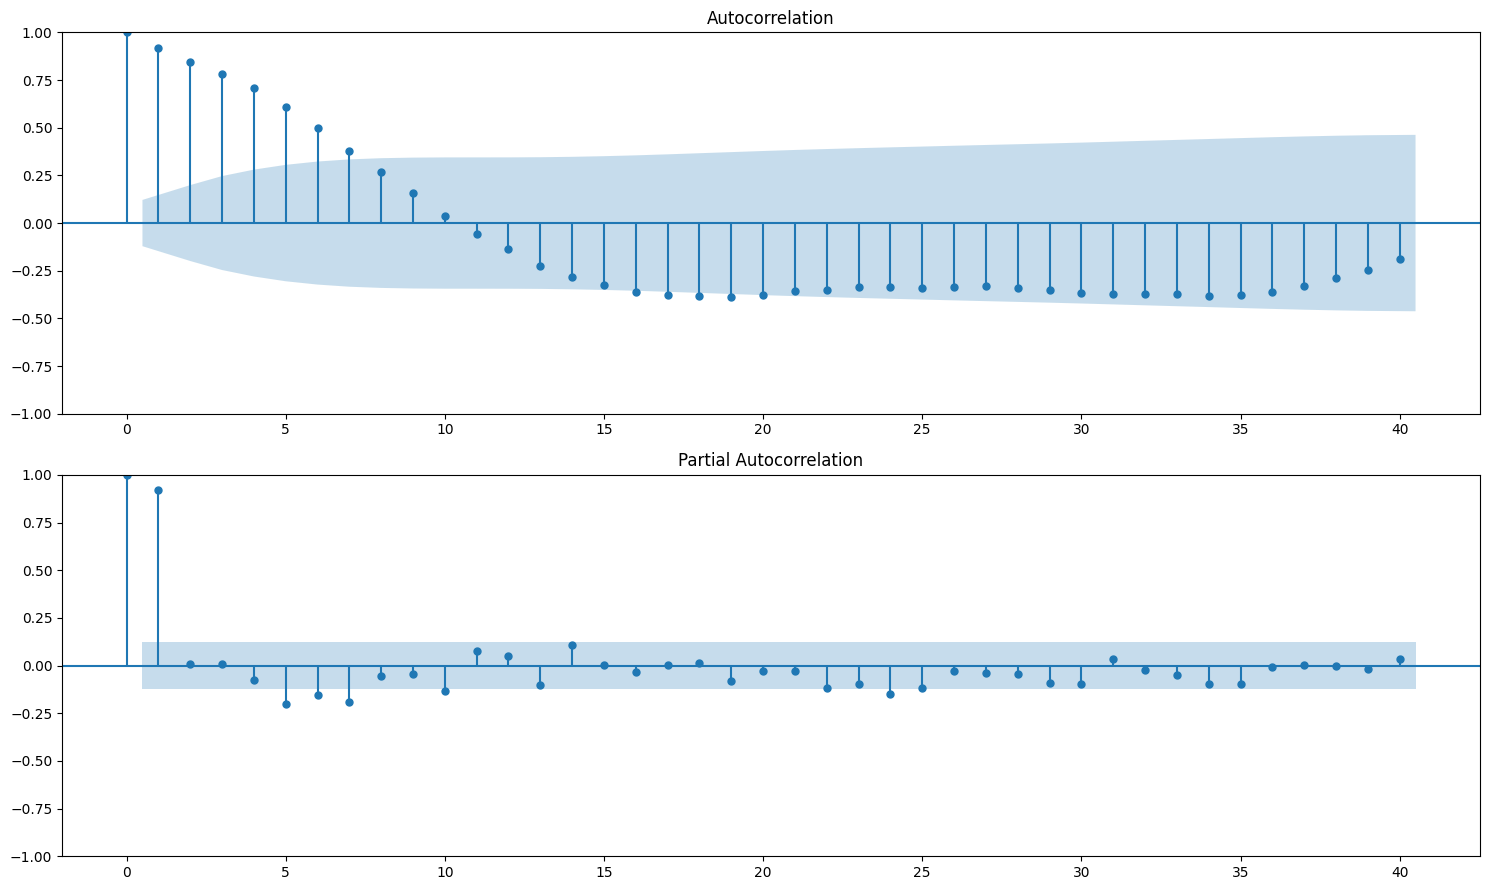

In [96]:
plt.figure(figsize=(15,9))

# Plot ACF
plt.subplot(2,1,1)
plot_acf(Train_max['maxtempC'].dropna(), ax=plt.gca(), lags=40)

# Plot PACF
plt.subplot(2,1,2)
plot_pacf(Train_max['maxtempC'].dropna(), ax=plt.gca(), lags=40)

# Show the plots
plt.tight_layout()
plt.show()

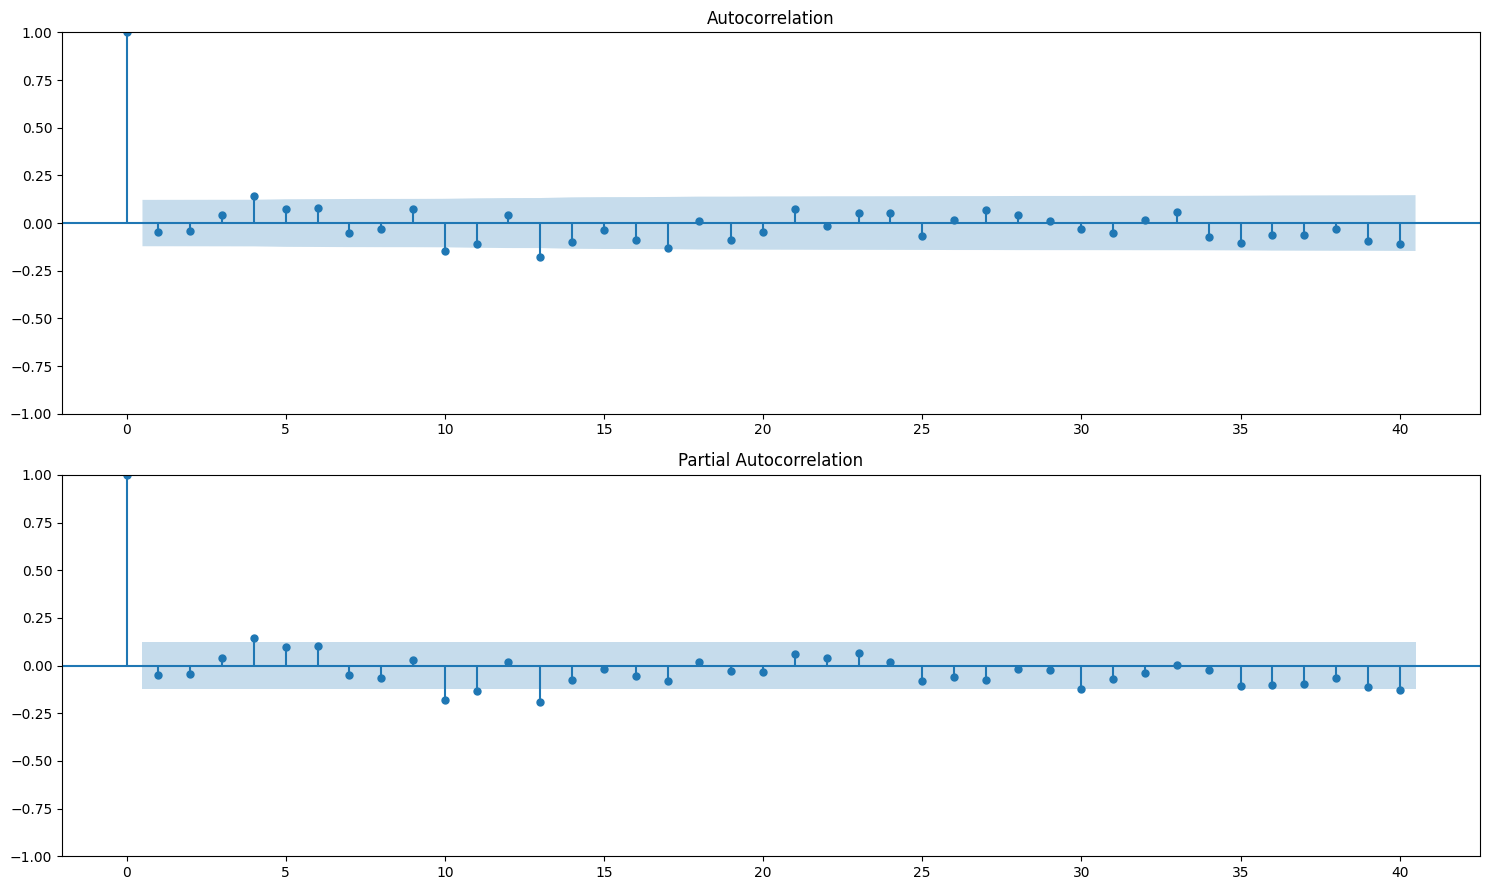

In [97]:
plt.figure(figsize=(15,9))

# Plot ACF
plt.subplot(2,1,1)
plot_acf(Train_max['one_time_diff'].dropna(), ax=plt.gca(), lags=40)

# Plot PACF
plt.subplot(2,1,2)
plot_pacf(Train_max['one_time_diff'].dropna(), ax=plt.gca(), lags=40)

# Show the plots
plt.tight_layout()
plt.show()

#### Creating Arima and Sarimax for Maximum temp. data

In [98]:
ar_model_3 = ARIMA(Train_max["maxtempC"], order=(10, 1, 10))
ar_model_3 = ar_model_3.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [99]:
ar_model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               maxtempC   No. Observations:                  261
Model:               ARIMA(10, 1, 10)   Log Likelihood                -484.453
Date:                Mon, 30 Sep 2024   AIC                           1010.907
Time:                        07:39:38   BIC                           1085.681
Sample:                    01-03-2016   HQIC                          1040.967
                         - 12-27-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5550      0.792     -0.701      0.484      -2.108       0.998
ar.L2         -0.5497      0.536     -1.026      0.305      -1.599       0.500
ar.L3          1.0633      0.378      2.812      0.005       0.322       1.804
ar.L4          0.8163      1.121      0.728      0.467      -1.381       3.014
ar.L5          0.7739      0.854      0.907      0.365      -0.899       2.447
ar.L6         -0.4677      0.591     -0.792      0.429      -1.625       0.690
ar.L7         -0.3819      0.789     -0.484      0.628      -1.928       1.164
ar.L8         -0.6541      0.601     -1.089      0.276      -1.832       0.523
ar.L9         -0.0612      0.479     -0.128      0.898      -0.999       0.877
ar.L10        -0.3026      0.273     -1.107      0.268      -0.838       0.233
ma.L1          0.3832      0.827      0.464      0.643      -1.237       2.004
ma.L2          0.3344      0.458      0.731      0.465      -0.563       1.232
ma.L3         -1.2681      0.345     -3.671      0.000      -1.945      -0.591
ma.L4         -0.6059      1.277     -0.475      0.635      -3.109       1.897
ma.L5         -0.4258      0.674     -0.632      0.527      -1.746       0.894
ma.L6          0.8821      0.460      1.919      0.055      -0.019       1.783
ma.L7          0.3004      1.079      0.278      0.781      -1.815       2.415
ma.L8          0.4364      0.469      0.931      0.352      -0.482       1.355
ma.L9         -0.1832      0.321     -0.571      0.568      -0.813       0.446
ma.L10         0.2142      0.415      0.516      0.606      -0.599       1.027
sigma2         2.3450      0.390      6.020      0.000       1.582       3.108
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               126.42
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                            -0.81
Prob(H) (two-sided):                  0.29   Kurtosis:                         6.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [100]:
ar_prediction_3 = ar_model_3.predict(start=Test_max.index[0], end=Test_max.index[-1])

In [101]:
Test_max["ARIMA_pred"] = round(ar_prediction_3)

In [102]:
mse = mean_squared_error(Test_max["maxtempC"], Test_max["ARIMA_pred"])
mse

11.320754716981131

In [103]:
rmse = np.sqrt(mse)
rmse

3.3646329245522657

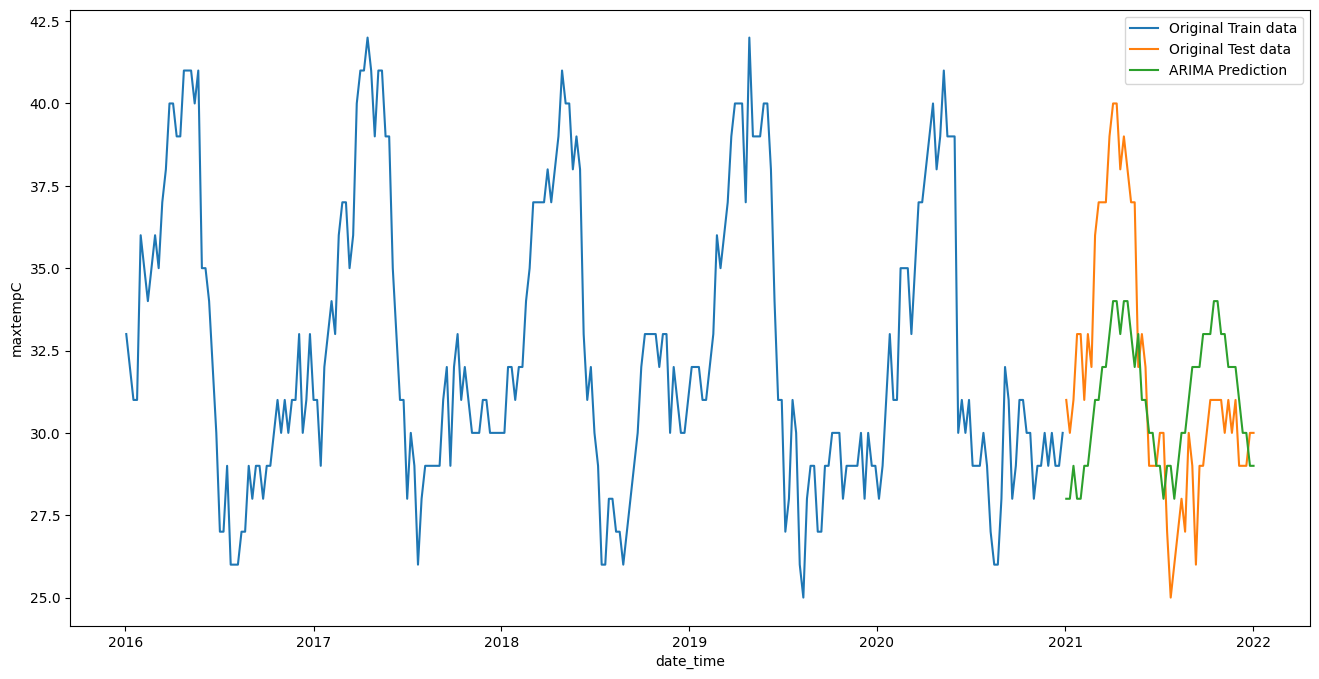

In [104]:
plt.figure(figsize=(16, 8))

sns.lineplot(data=Train_max, x='date_time', y='maxtempC', label="Original Train data")
sns.lineplot(data=Test_max, x='date_time', y='maxtempC', label="Original Test data")
sns.lineplot(data=Test_max, x='date_time', y='ARIMA_pred', label="ARIMA Prediction")

plt.show()

In [105]:
sar_model_3 = SARIMAX(Train_max["maxtempC"], order=(1, 0, 1), seasonal_order=(4, 1, 4, 52))
sar_model_3 = sar_model_3.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [106]:
sar_model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           SARIMAX Results                                           
=====================================================================================================
Dep. Variable:                                      maxtempC   No. Observations:                  261
Model:             SARIMAX(1, 0, 1)x(4, 1, [1, 2, 3, 4], 52)   Log Likelihood                -399.632
Date:                                       Mon, 30 Sep 2024   AIC                            821.264
Time:                                               07:48:03   BIC                            858.030
Sample:                                           01-03-2016   HQIC                           836.129
                                                - 12-27-2020                                         
Covariance Type:                                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5409      0.135      4.018      0.000       0.277       0.805
ma.L1         -0.1115      0.156     -0.716      0.474      -0.417       0.194
ar.S.L52      -0.3378   1.34e+04  -2.52e-05      1.000   -2.62e+04    2.62e+04
ar.S.L104     -0.1835   1.56e+04  -1.18e-05      1.000   -3.05e+04    3.05e+04
ar.S.L156     -0.0107   5828.543  -1.83e-06      1.000   -1.14e+04    1.14e+04
ar.S.L208     -0.1959   6437.409  -3.04e-05      1.000   -1.26e+04    1.26e+04
ma.S.L52      -0.2783   1.52e+04  -1.83e-05      1.000   -2.98e+04    2.98e+04
ma.S.L104     -0.2502   1.82e+04  -1.37e-05      1.000   -3.57e+04    3.57e+04
ma.S.L156      0.0755   8715.531   8.66e-06      1.000   -1.71e+04    1.71e+04
ma.S.L208     -0.0685   4844.719  -1.41e-05      1.000   -9495.543    9495.406
sigma2         2.0694   4048.702      0.001      1.000   -7933.240    7937.379
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.15
Prob(Q):                              0.95   Prob(JB):                         0.34
Heteroskedasticity (H):               1.13   Skew:                             0.04
Prob(H) (two-sided):                  0.61   Kurtosis:                         3.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [107]:
sar_prediction_3 = sar_model_3.predict(start=Test_max.index[0], end=Test_max.index[-1])

In [108]:
Test_max["SARIMAX_pred"] = round(sar_prediction_3)

In [109]:
mse_3 = mean_squared_error(Test_max["maxtempC"], Test_max["SARIMAX_pred"])
mse_3

3.188679245283019

In [110]:
rmse_3 = np.sqrt(mse_3)
rmse_3

1.7856873313329573

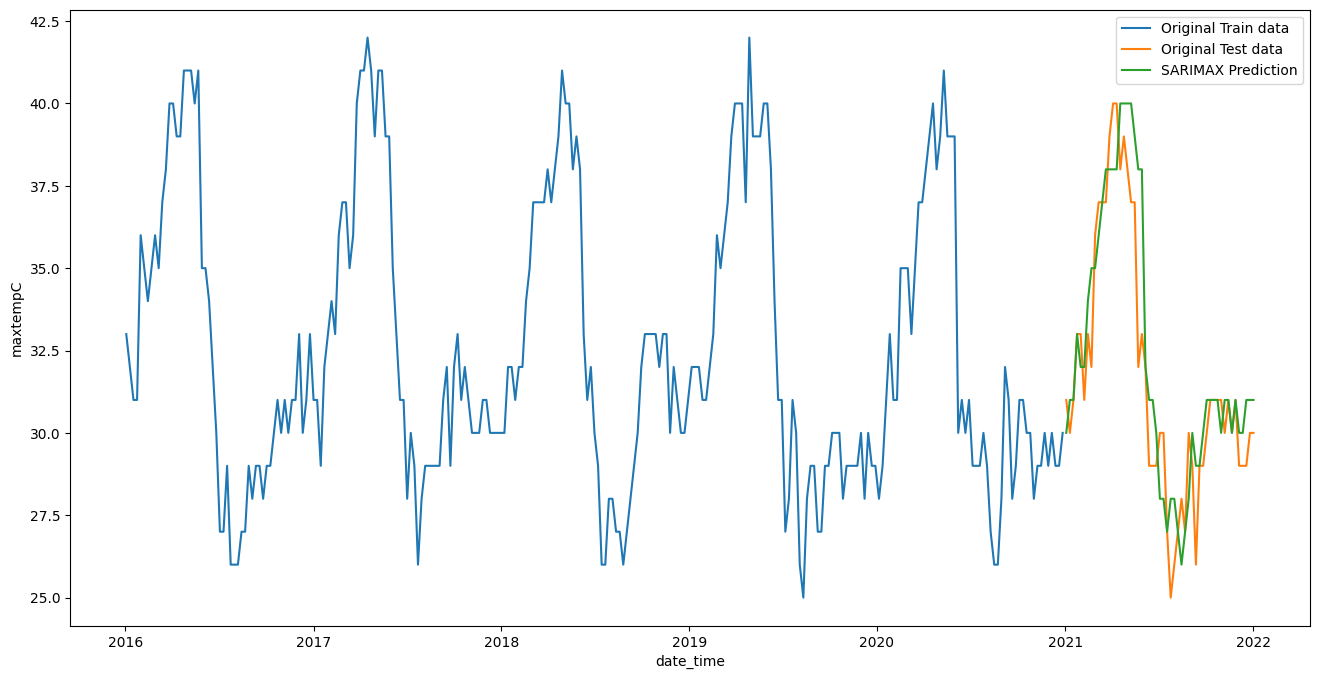

In [111]:
plt.figure(figsize=(16, 8))

sns.lineplot(data=Train_max, x='date_time', y='maxtempC', label="Original Train data")
sns.lineplot(data=Test_max, x='date_time', y='maxtempC', label="Original Test data")
sns.lineplot(data=Test_max, x='date_time', y='SARIMAX_pred', label="SARIMAX Prediction")

plt.show()

In [112]:
new_data["max_temp_pred"] = sar_model_3.predict(start=new_data.index[0], end=new_data.index[-1])

In [113]:
new_data["max_temp_pred"] = round(new_data["max_temp_pred"])

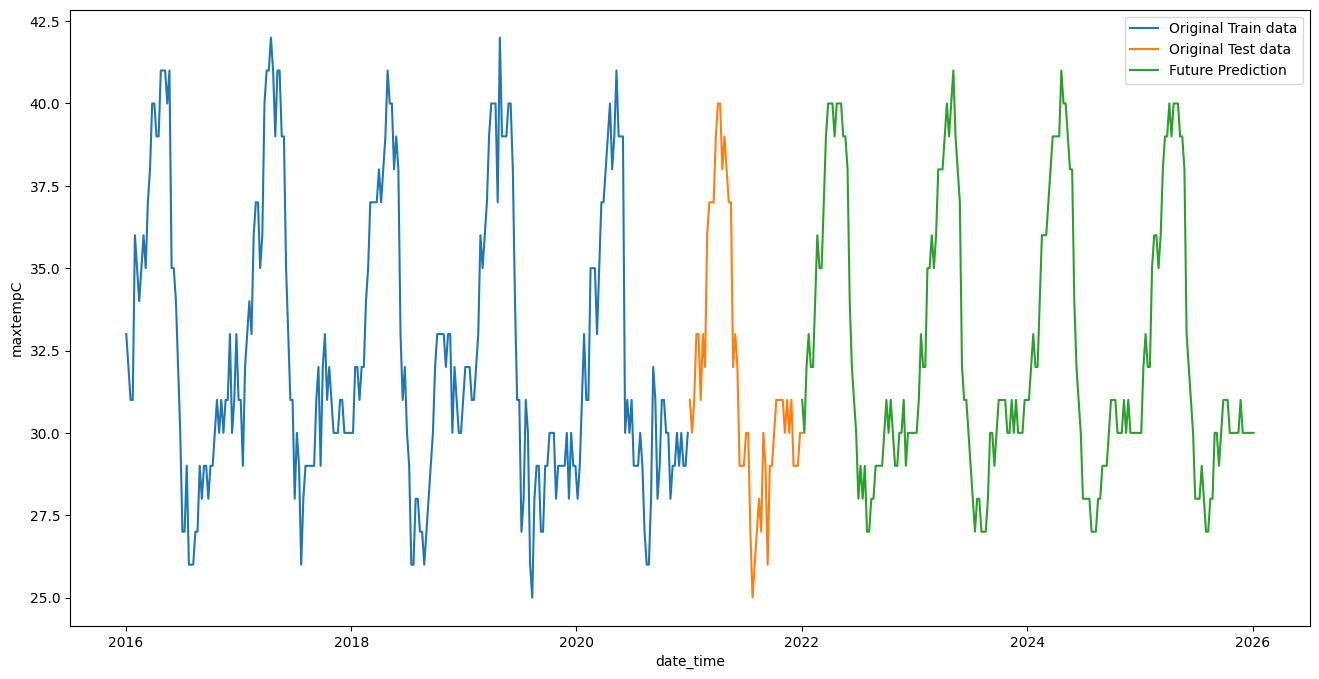

In [114]:
plt.figure(figsize=(16, 8))

sns.lineplot(data=Train_max, x='date_time', y='maxtempC', label="Original Train data")
sns.lineplot(data=Test_max, x='date_time', y='maxtempC', label="Original Test data")
sns.lineplot(data=new_data, x='date_time', y='max_temp_pred', label="Future Prediction")

plt.show()

In [115]:
new_data.head()

avg_temp_pred  min_temp_pred  max_temp_pred
date_time                                              
2022-01-02           22.0           15.0           31.0
2022-01-09           23.0           15.0           30.0
2022-01-16           23.0           16.0           32.0
2022-01-23           24.0           17.0           33.0
2022-01-30           24.0           16.0           32.0

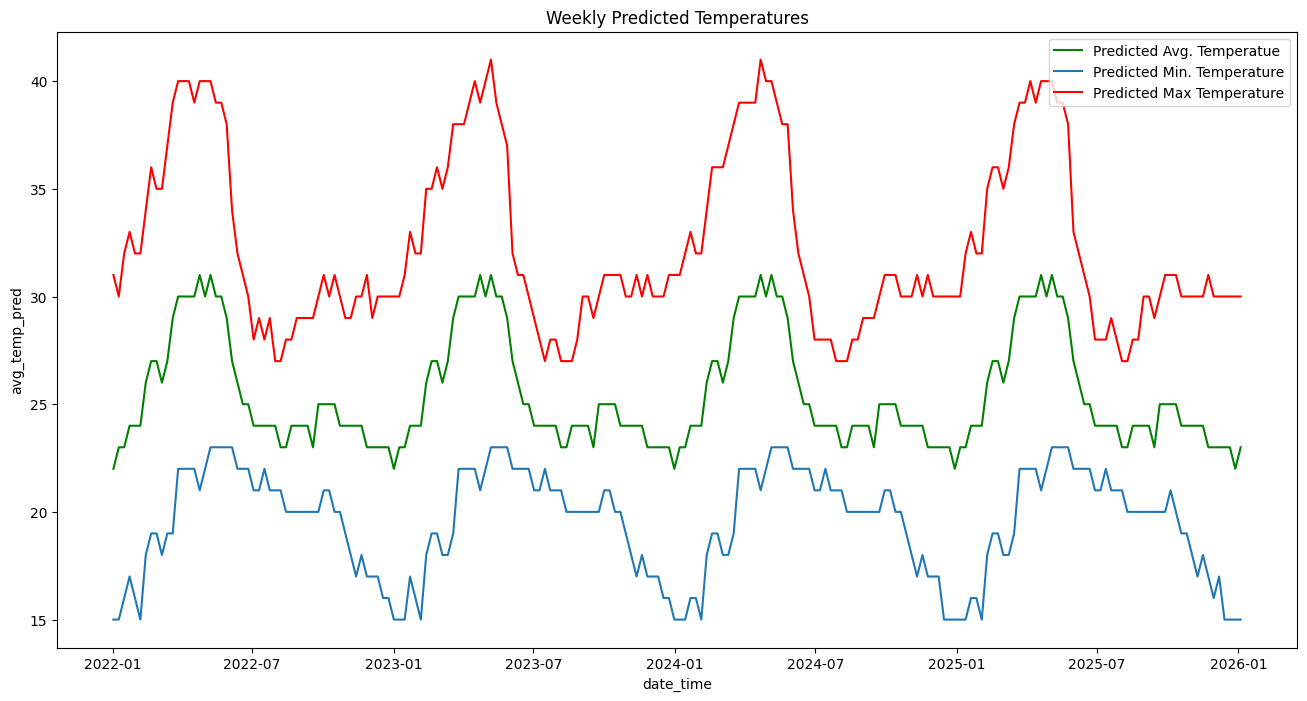

In [116]:
# plotting predicted minimum, average, maximum temperatures
plt.figure(figsize=(16, 8))

sns.lineplot(data=new_data, x='date_time', y='avg_temp_pred', label="Predicted Avg. Temperatue", color="green")
sns.lineplot(data=new_data, x='date_time', y='min_temp_pred', label="Predicted Min. Temperature")
sns.lineplot(data=new_data, x='date_time', y='max_temp_pred', label="Predicted Max Temperature", color="red")
plt.title("Weekly Predicted Temperatures")
plt.show()

In [117]:
#the tabular format of predicted weekly data
new_data.iloc[104:160,:]

avg_temp_pred  min_temp_pred  max_temp_pred
date_time                                              
2023-12-31           22.0           15.0           31.0
2024-01-07           23.0           15.0           31.0
2024-01-14           23.0           15.0           32.0
2024-01-21           24.0           16.0           33.0
2024-01-28           24.0           16.0           32.0
2024-02-04           24.0           15.0           32.0
2024-02-11           26.0           18.0           34.0
2024-02-18           27.0           19.0           36.0
2024-02-25           27.0           19.0           36.0
2024-03-03           26.0           18.0           36.0
2024-03-10           27.0           18.0           37.0
2024-03-17           29.0           19.0           38.0
2024-03-24           30.0           22.0           39.0
2024-03-31           30.0           22.0           39.0
2024-04-07           30.0           22.0           39.0
2024-04-14           30.0           22.0           39.0
2024-04-21           31.0           21.0           41.0
2024-04-28           30.0           22.0           40.0
2024-05-05           31.0           23.0           40.0
2024-05-12           30.0           23.0           39.0
2024-05-19           30.0           23.0           38.0
2024-05-26           29.0           23.0           38.0
2024-06-02           27.0           22.0           34.0
2024-06-09           26.0           22.0           32.0
2024-06-16           25.0           22.0           31.0
2024-06-23           25.0           22.0           30.0
2024-06-30           24.0           21.0           28.0
2024-07-07           24.0           21.0           28.0
2024-07-14           24.0           22.0           28.0
2024-07-21           24.0           21.0           28.0
2024-07-28           24.0           21.0           27.0
2024-08-04           23.0           21.0           27.0
2024-08-11           23.0           20.0           27.0
2024-08-18           24.0           20.0           28.0
2024-08-25           24.0           20.0           28.0
2024-09-01           24.0           20.0           29.0
2024-09-08           24.0           20.0           29.0
2024-09-15           23.0           20.0           29.0
2024-09-22           25.0           20.0           30.0
2024-09-29           25.0           21.0           31.0
2024-10-06           25.0           21.0           31.0
2024-10-13           25.0           20.0           31.0
2024-10-20           24.0           20.0           30.0
2024-10-27           24.0           19.0           30.0
2024-11-03           24.0           18.0           30.0
2024-11-10           24.0           17.0           31.0
2024-11-17           24.0           18.0           30.0
2024-11-24           23.0           17.0           31.0
2024-12-01           23.0           17.0           30.0
2024-12-08           23.0           17.0           30.0
2024-12-15           23.0           15.0           30.0
2024-12-22           23.0           15.0           30.0
2024-12-29           22.0           15.0           30.0
2025-01-05           23.0           15.0           30.0
2025-01-12           23.0           15.0           32.0
2025-01-19           24.0           16.0           33.0